In [1]:
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML

In [2]:
import torch
from model_common import *
from model_bank import *

In [3]:
!nvidia-smi

Wed Nov 24 05:14:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
gpu, cpu = get_devices()

In [5]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mels.pkl')
ragam_te_to_en = {
    'సామంతం' : 'Samantham',
    'దేసాళం' : 'Desalam',
    'రామక్రియ' : 'Ramakriya',
    'కన్నడగౌళ' : 'Kannadagowla',
    'శంకరాభరణం' : 'Sankarabharanam',
    'దేవగాంధారి' : 'Devagandhari',
    'ఆహిరి' : 'Aahiri',
    'ముఖారి' : 'Mukhari',
    'నాట' : 'Naata',
    'శుద్ధవసంతం' : 'Suddavasantham',
    'సాళంగనాట' : 'Salanganata',
    'లలిత' : 'Lalitha',
    'భూపాలం' : 'Bhupalam',
    'ధన్నాసి' : 'Dhannasi',
    'కాంబోది' : 'Kambodhi',
    'బౌళి' : 'Bauli',
    'గుండుక్రియ' : 'Gundukriya',
    'శ్రీరాగం' : 'Sriragam',
    'భైరవి' : 'Bhairavi',
    'పాడి' : 'Paadi',
    'మాళవి' : 'Maalavi',
    'నాదరామక్రియ' : 'Nadaramakriya',
    'మలహరి' : 'Malahari',
    'వరాళి' : 'Varali',
    'గౌళ' : 'Gowla',
    'సాళంగం' : 'Salangam',
    'బౌళిరామక్రియ' : 'Bauliramakriya',
    'మాళవిగౌళ' : 'Malavigowla',
    'గుజ్జరి' : 'Gujjari',
    'దేసాక్షి' : 'Desakshi'
}
data['Ragam'].replace(ragam_te_to_en,inplace=True)

In [6]:
data['Ragam'].value_counts()

Lalitha            98
Salanganata        94
Samantham          89
Bauli              70
Sankarabharanam    68
Sriragam           65
Ramakriya          61
Mukhari            55
Paadi              49
Aahiri             45
Desalam            40
Devagandhari       35
Suddavasantham     33
Bhupalam           32
Desakshi           29
Gundukriya         28
Bhairavi           27
Naata              25
Varali             22
Dhannasi           20
Malahari           20
Kambodhi           19
Malavigowla        18
Maalavi            18
Kannadagowla       15
Gujjari            15
Gowla              14
Bauliramakriya     13
Nadaramakriya      11
Salangam           11
Name: Ragam, dtype: int64

In [7]:
data['Ragam'].value_counts()

Lalitha            98
Salanganata        94
Samantham          89
Bauli              70
Sankarabharanam    68
Sriragam           65
Ramakriya          61
Mukhari            55
Paadi              49
Aahiri             45
Desalam            40
Devagandhari       35
Suddavasantham     33
Bhupalam           32
Desakshi           29
Gundukriya         28
Bhairavi           27
Naata              25
Varali             22
Dhannasi           20
Malahari           20
Kambodhi           19
Malavigowla        18
Maalavi            18
Kannadagowla       15
Gujjari            15
Gowla              14
Bauliramakriya     13
Nadaramakriya      11
Salangam           11
Name: Ragam, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
Y1, Y2 = train_test_split(data['Ragam'], test_size=0.1, random_state=42)

train_data = data.loc[Y1.index]
test_data = data.loc[Y2.index]

In [9]:
train_data['Ragam'].value_counts()

Lalitha            88
Salanganata        87
Samantham          76
Bauli              65
Sankarabharanam    61
Sriragam           61
Ramakriya          54
Mukhari            51
Paadi              45
Aahiri             41
Desalam            36
Devagandhari       30
Bhupalam           30
Suddavasantham     28
Bhairavi           26
Desakshi           25
Gundukriya         25
Naata              24
Varali             20
Dhannasi           19
Malahari           17
Kambodhi           17
Kannadagowla       15
Malavigowla        14
Maalavi            14
Gujjari            13
Bauliramakriya     12
Gowla              11
Nadaramakriya      10
Salangam           10
Name: Ragam, dtype: int64

In [10]:
class MelMatrixDataset(AbsDataset):
    def __init__(self, labels, mels):
        super().__init__()
        self.labels = labels
        self.mels = mels

    def __get__(self,index):
      if self.mels[index].shape[1] < 9601:
        self.mels[index] = torch.hstack((self.mels[index],torch.zeros(40,9601-self.mels[index].shape[1])))
      return self.mels[index].reshape((1,)+self.mels[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mel_spec'].iloc[x] for x in train_ids]
      test_vals = [data['mel_spec'].iloc[x] for x in test_ids]
      train_data = MelMatrixDataset(train_lbls, train_vals)
      test_data = MelMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [11]:
class MelRaga(nn.Module):
    def __init__(self, n_labels=2, dropout=0.25):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
        self.final = nn.Sequential(nn.Linear(48000, 1000),nn.ReLU(), nn.Linear(1000, n_labels))
        
    def forward(self,x):
        return self.final(self.cnn(x))
    
    def __del__(self):
        self.to(cpu)

In [12]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2, nindex_factor=None):
  results = {}
  models = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if nsamples == 0:
      continue
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])[0]
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    
    if nindex_factor:
      np.random.seed(42)
      ndata = pd.DataFrame()
      ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
      ndata[feature] = data[feature]
      pindex = ndata[ndata[target]==1].index
      nindex = ndata[ndata[target]==0].index
      index = np.random.choice(pindex,pindex.shape[0]).tolist() + np.random.choice(nindex,nindex_factor*pindex.shape[0]).tolist()
      tdata = ndata.loc[index]
    else:
      tdata = pd.DataFrame()
      tdata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
      tdata[feature] = data[feature]

    models[lbl] = f'{lbl}.pt'
    results[i] = train_model(tdata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : f'{title} - {lbl}',
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target,
                                   'model_name' : models[lbl]})
    print(results_to_df(results[i]))
    
  return results, models

Training for Aahiri with 41 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 196/50
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 8.050 / Validation Loss : 10.851 [Time : 1.19652 seconds]
Epoch 2/15 : Training Loss: 9.099 / Validation Loss : 10.903 [Time : 0.525315 seconds]
Epoch 3/15 : Training Loss: 8.472 / Validation Loss : 9.181 [Time : 0.949928 seconds]
Epoch 4/15 : Training Loss: 6.423 / Validation Loss : 6.519 [Time : 1.701847 seconds]
Epoch 5/15 : Training Loss: 3.575 / Validation Loss : 2.952 [Time : 0.94357 seconds]
Epoch 6/15 : Training Loss: 0.744 / Validation Loss : 1.338 [Time : 0.905984 seconds]
Epoch 7/15 : Training Loss: 0.207 / Validation Loss : 1.204 [Time : 0.899327 seconds]
Epoch 8/15 : Training Loss: 0.060 / Validation Loss : 1.998 [Time : 0.517754 seconds]
Epoch 9/15 : Training Loss: 0.111 / Validation Loss : 1.959 [Time : 0.514856 seconds]
Epoch 10/15 : Training Loss: 0.086 / Validation Loss : 1.613 [Time : 0.512818 seconds]
Epoch 11/15 : Training Los

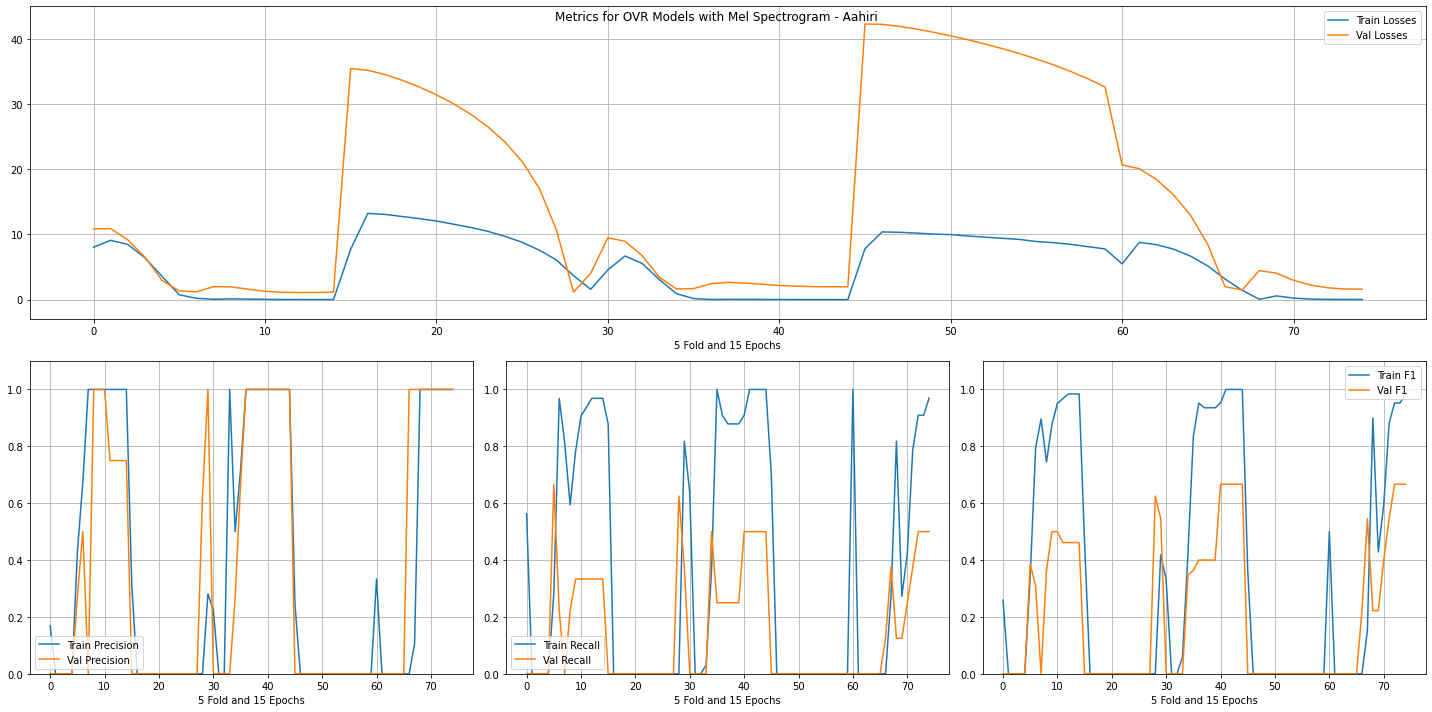

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.666667  ...      0.013670           2.059978
12  1.000000       0.666667  ...      0.010726           1.992975
13  1.000000       0.666667  ...      0.009631           1.968642
14  1.000000       0.666667  ...      0.008342           1.973279
14  0.984615       0.666667  ...      0.030261           1.612405
..       ...            ...  ...           ...                ...
1   0.000000       0.000000  ...      8.787409          20.091230
2   0.000000       0.000000  ...      8.442399          18.446753
3   0.000000       0.000000  ...      7.746536          16.081549
4   0.000000       0.000000  ...      6.666841          12.895851
5   0.000000       0.000000  ...      5.164333           8.438976

[75 rows x 12 columns]
Training for Bauli with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 72/18
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 7.228 / Validation Loss : 14.419 [Time : 0.51

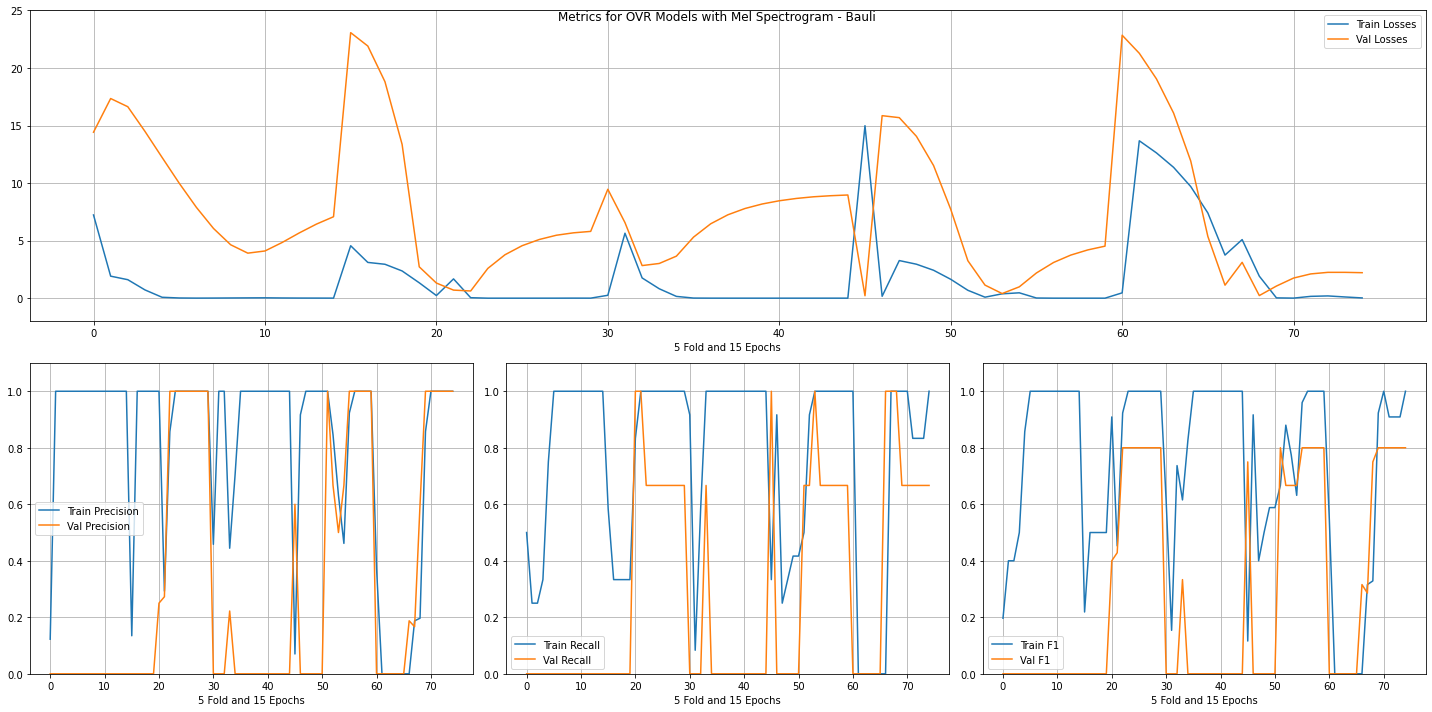

    train_f1  validation_f1  ...  train_losses  validation_losses
8        1.0            0.8  ...      0.000528           2.585455
9        1.0            0.8  ...      0.000029           3.771180
10       1.0            0.8  ...      0.000219           4.559348
11       1.0            0.8  ...      0.001242           5.097435
12       1.0            0.8  ...      0.001250           5.468404
..       ...            ...  ...           ...                ...
1        0.0            0.0  ...     13.674113          21.275257
2        0.0            0.0  ...     12.621970          19.051706
3        0.0            0.0  ...     11.366752          16.082832
4        0.0            0.0  ...      9.698272          11.919523
5        0.0            0.0  ...      7.400794           5.357717

[75 rows x 12 columns]
Training for Bauliramakriya with 17 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 81/21
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 9.286 / Validation Loss : 3.101 [Tim

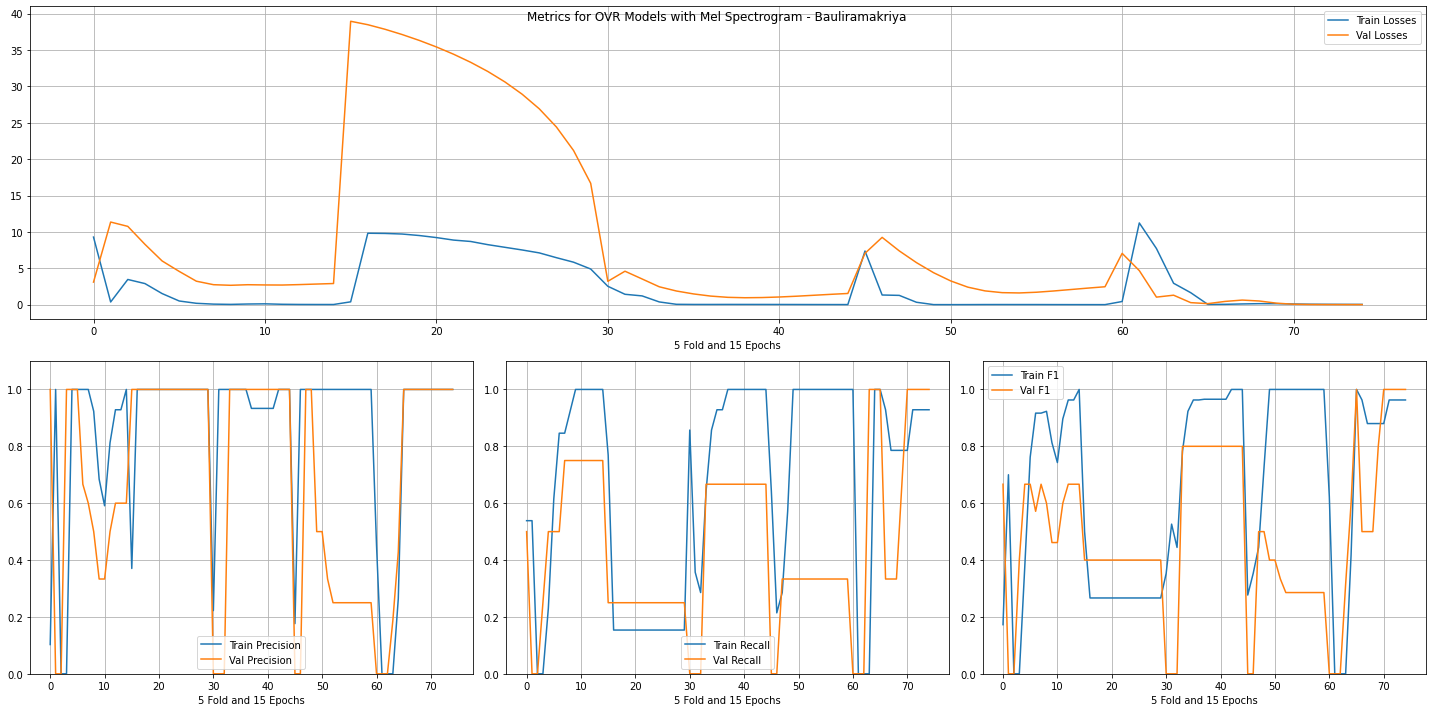

    train_f1  validation_f1  ...  train_losses  validation_losses
5   1.000000            1.0  ...      0.031320           0.138292
11  0.962963            1.0  ...      0.058456           0.017261
12  0.962963            1.0  ...      0.047745           0.008166
13  0.962963            1.0  ...      0.039847           0.005649
14  0.962963            1.0  ...      0.034741           0.004930
..       ...            ...  ...           ...                ...
1   0.352941            0.0  ...      1.325924           9.249208
0   0.276923            0.0  ...      7.376115           7.058091
2   0.000000            0.0  ...      3.461218          10.760126
1   0.000000            0.0  ...     11.232057           4.680326
2   0.000000            0.0  ...      7.716124           1.035621

[75 rows x 12 columns]
Training for Bhairavi with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 120/30
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 7.617 / Validation Loss : 8.437 [Time : 0

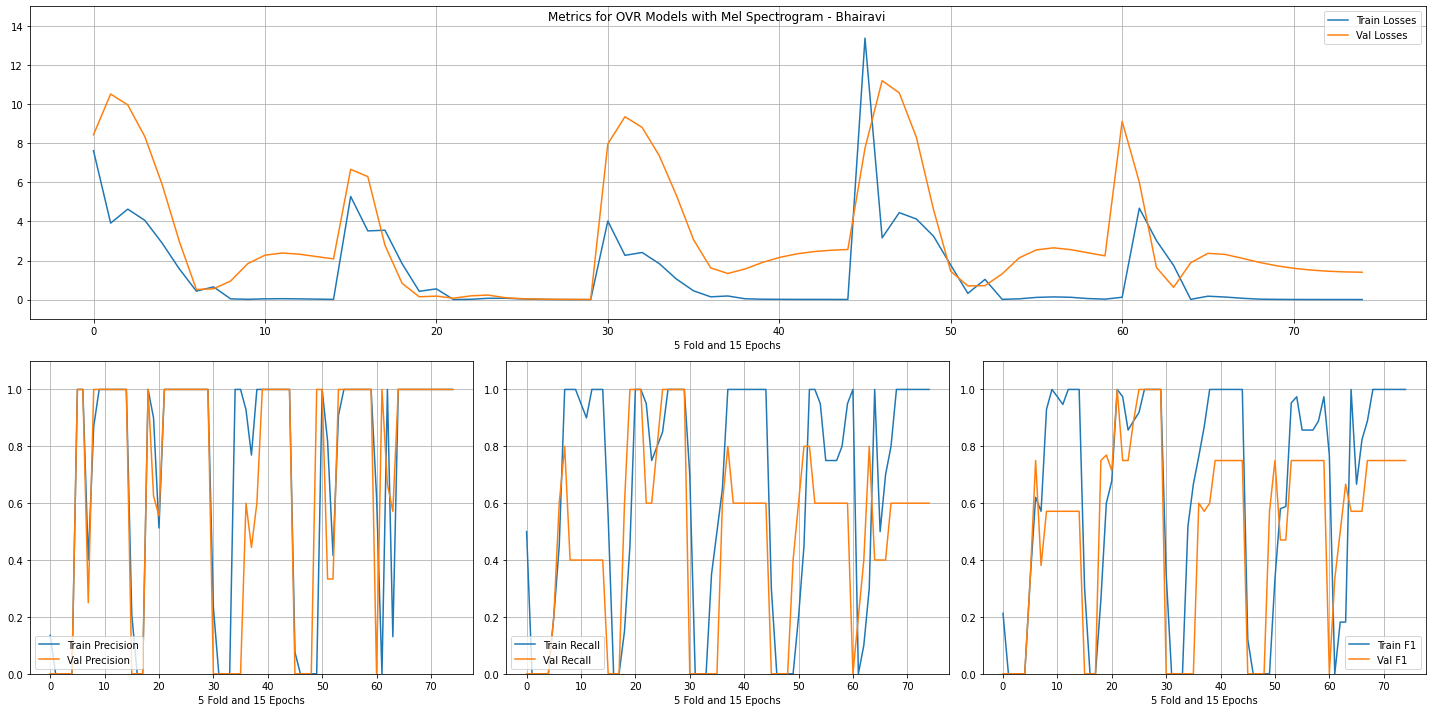

    train_f1  validation_f1  ...  train_losses  validation_losses
6        1.0            1.0  ...      0.006195           0.074253
11       1.0            1.0  ...      0.015263           0.026549
12       1.0            1.0  ...      0.007768           0.015947
13       1.0            1.0  ...      0.004237           0.010690
14       1.0            1.0  ...      0.003024           0.007906
..       ...            ...  ...           ...                ...
2        0.0            0.0  ...      2.412242           8.811539
3        0.0            0.0  ...      1.844167           7.364372
1        0.0            0.0  ...      3.160509          11.202760
2        0.0            0.0  ...      4.451216          10.575191
3        0.0            0.0  ...      4.122689           8.296132

[75 rows x 12 columns]
Training for Bhupalam with 13 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 62/16
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 4.310 / Validation Loss : 10.427 [Time : 0

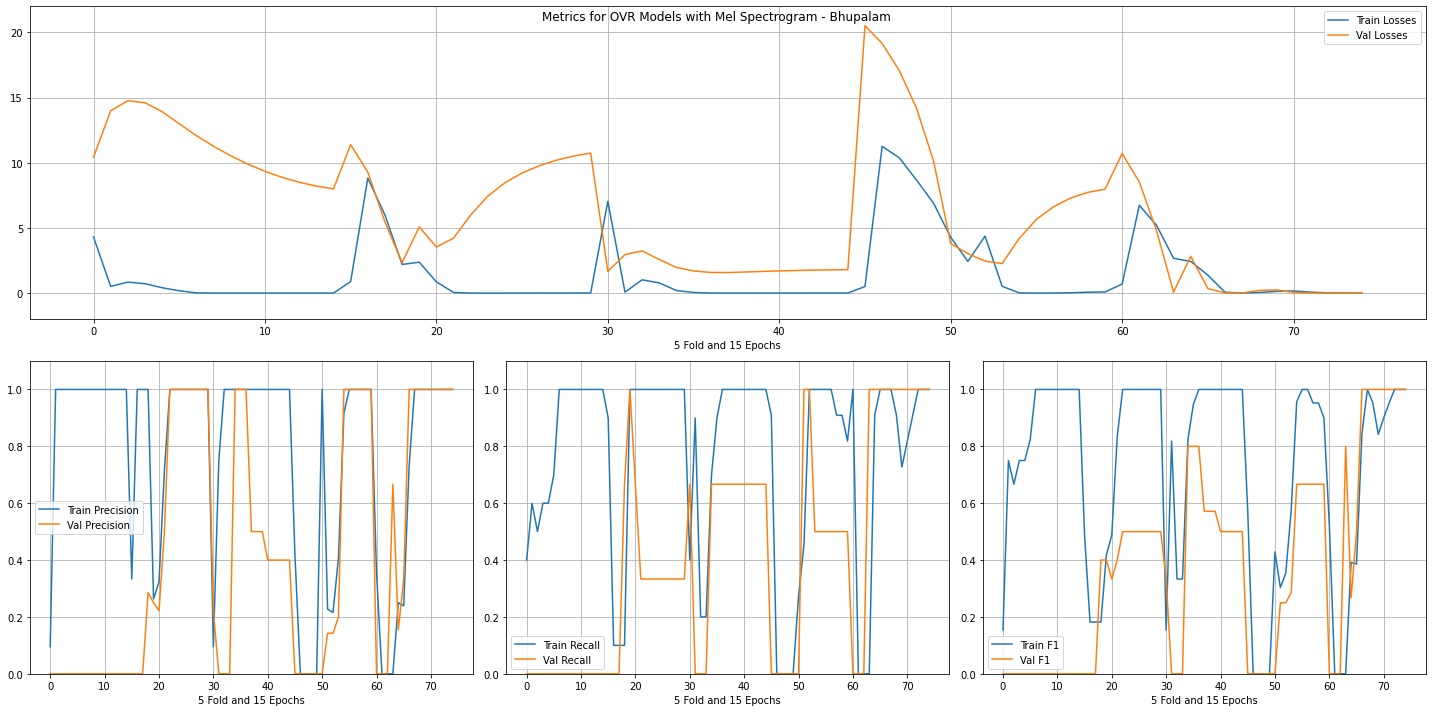

    train_f1  validation_f1  ...  train_losses  validation_losses
7   1.000000            1.0  ...      0.011170           0.013404
12  1.000000            1.0  ...      0.023625           0.001016
13  1.000000            1.0  ...      0.007762           0.000298
14  1.000000            1.0  ...      0.002337           0.000175
8   0.952381            1.0  ...      0.049968           0.207650
..       ...            ...  ...           ...                ...
2   0.000000            0.0  ...     10.385243          17.079498
3   0.000000            0.0  ...      8.684474          14.213483
4   0.000000            0.0  ...      6.895326          10.127646
1   0.000000            0.0  ...      6.742493           8.532993
2   0.000000            0.0  ...      5.215970           4.823549

[75 rows x 12 columns]
Training for Desakshi with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 52/14
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.813 / Validation Loss : 10.319 [Time : 4

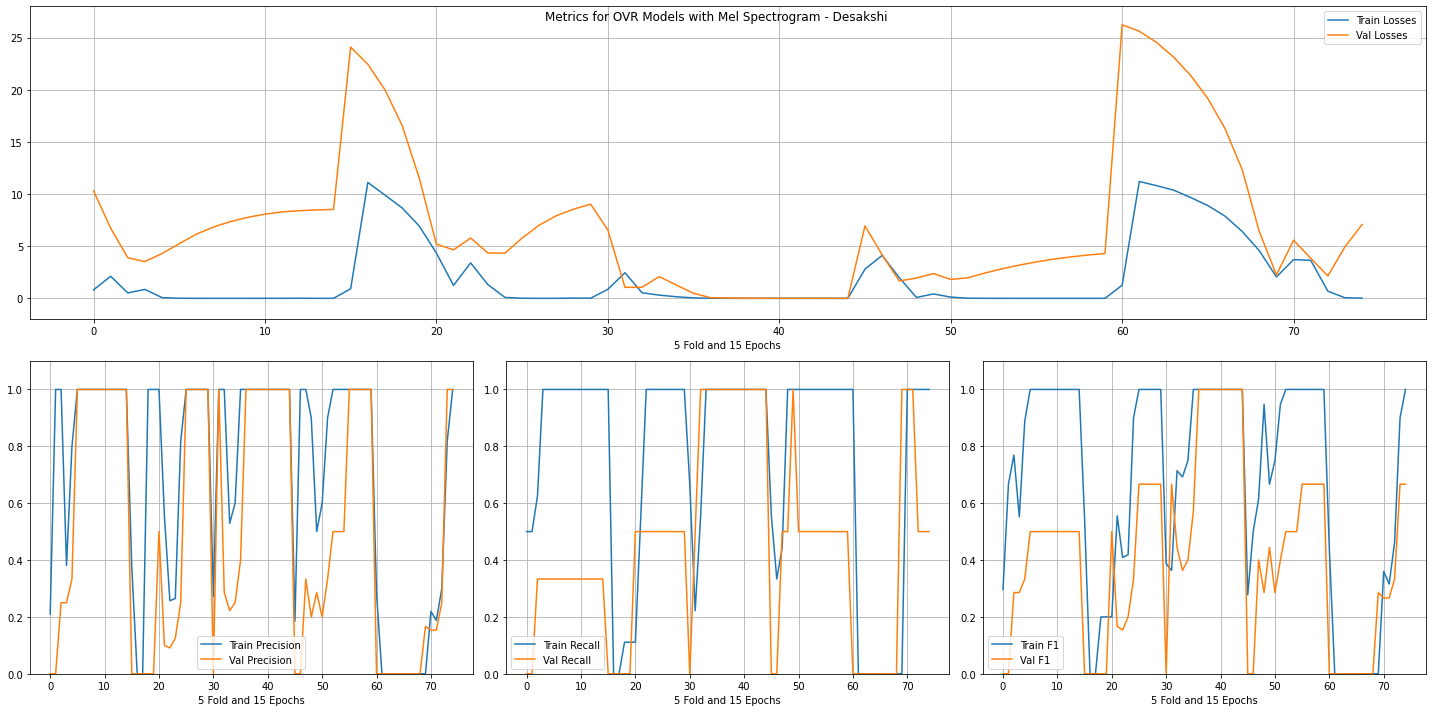

    train_f1  validation_f1  ...  train_losses  validation_losses
6        1.0            1.0  ...      0.007693           0.061686
7        1.0            1.0  ...      0.002241           0.030818
8        1.0            1.0  ...      0.000796           0.018787
9        1.0            1.0  ...      0.000350           0.012505
10       1.0            1.0  ...      0.000183           0.008920
..       ...            ...  ...           ...                ...
4        0.0            0.0  ...      9.666784          21.375607
5        0.0            0.0  ...      8.898658          19.160246
6        0.0            0.0  ...      7.885528          16.285357
7        0.0            0.0  ...      6.418663          12.351965
8        0.0            0.0  ...      4.573413           6.399861

[75 rows x 12 columns]
Training for Desalam with 30 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 144/36
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 10.174 / Validation Loss : 6.294 [Time : 0

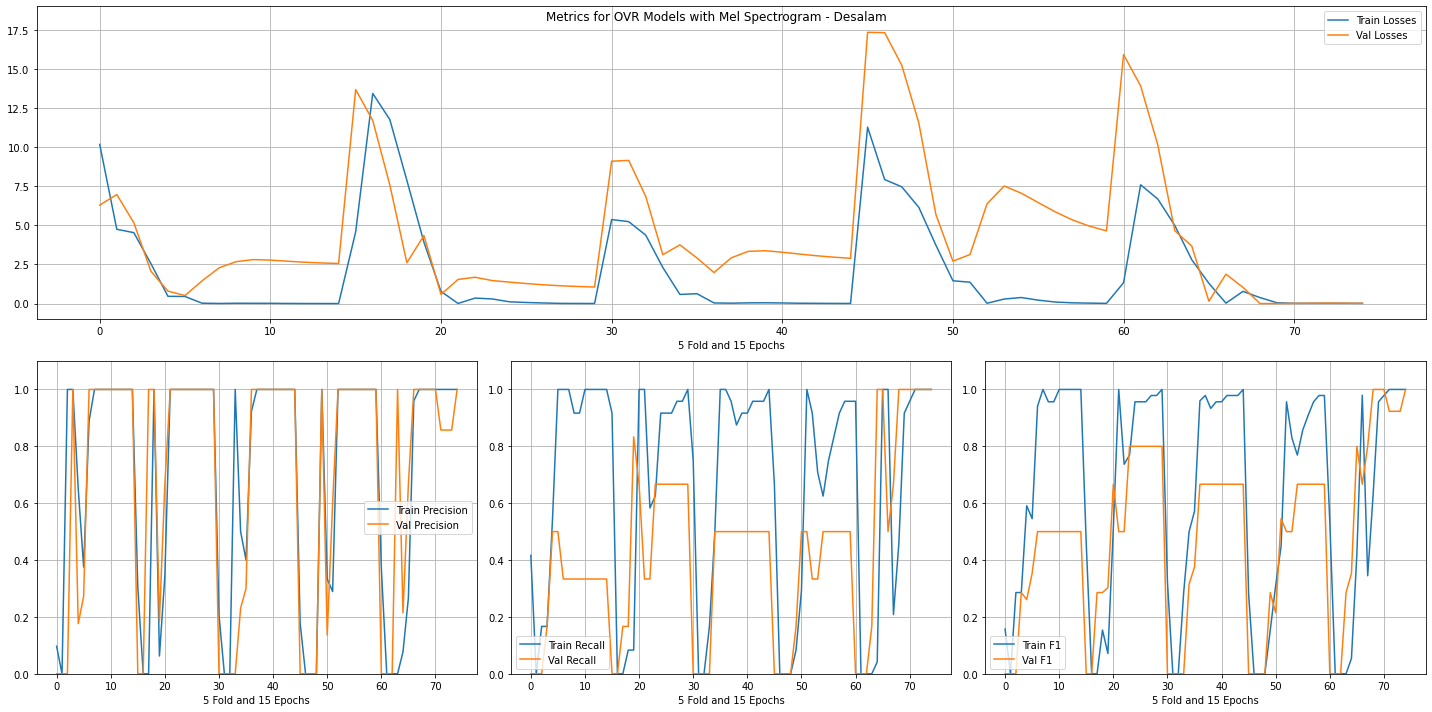

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       1.000000  ...      0.013354           0.014856
10  0.978723       1.000000  ...      0.016657           0.009677
9   0.956522       1.000000  ...      0.049462           0.002762
8   0.628571       1.000000  ...      0.379033           0.001058
11  1.000000       0.923077  ...      0.015955           0.021729
..       ...            ...  ...           ...                ...
1   0.000000       0.000000  ...      7.927370          17.319750
2   0.000000       0.000000  ...      7.465247          15.241781
3   0.000000       0.000000  ...      6.155462          11.556553
1   0.000000       0.000000  ...      7.593561          13.914922
2   0.000000       0.000000  ...      6.690374          10.164911

[75 rows x 12 columns]
Training for Devagandhari with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 120/30
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 9.849 / Validation Loss : 7.049 [Time

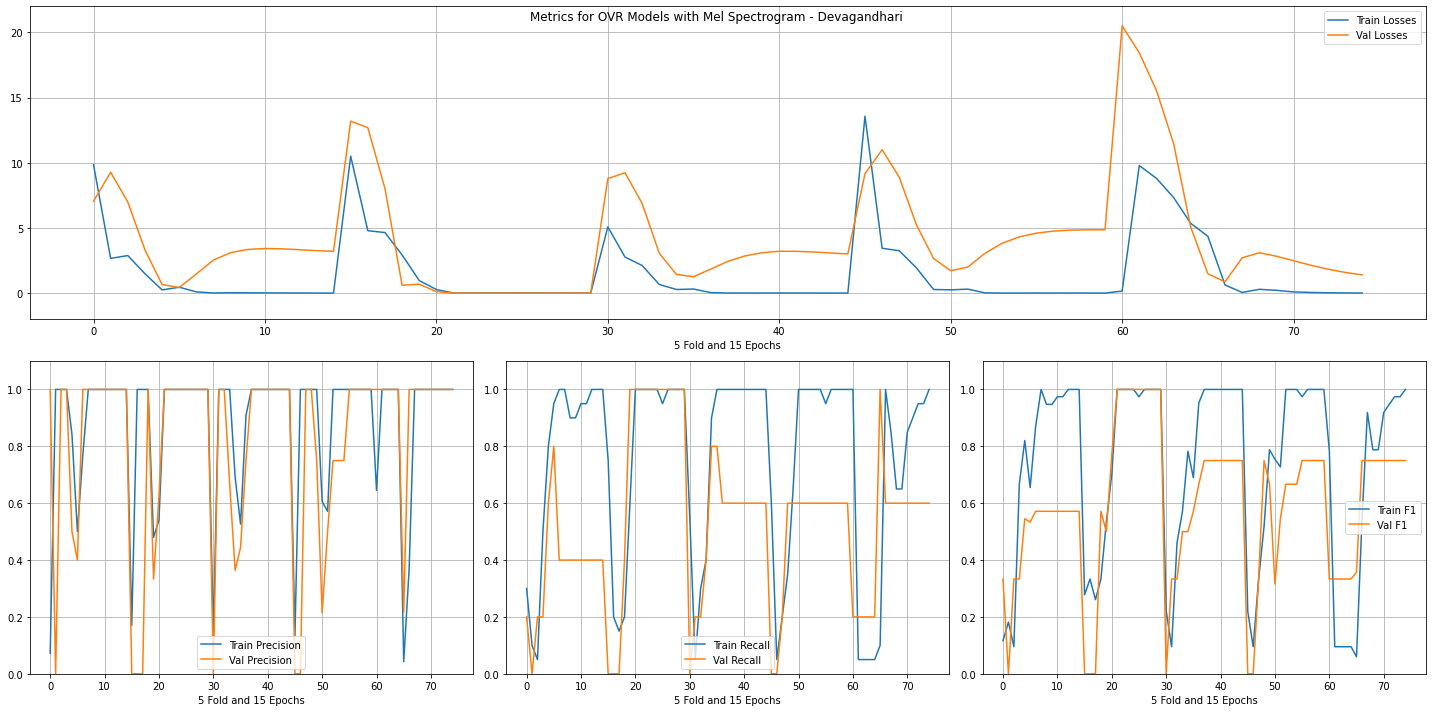

    train_f1  validation_f1  ...  train_losses  validation_losses
6   1.000000            1.0  ...      0.007373           0.002607
7   1.000000            1.0  ...      0.003824           0.000400
8   1.000000            1.0  ...      0.008768           0.000166
9   1.000000            1.0  ...      0.011743           0.000127
11  1.000000            1.0  ...      0.003801           0.000114
..       ...            ...  ...           ...                ...
2   0.260870            0.0  ...      4.648463           8.029010
0   0.222222            0.0  ...      5.084819           8.787456
0   0.220183            0.0  ...     13.577555           9.167103
1   0.181818            0.0  ...      2.668805           9.274828
1   0.095238            0.0  ...      3.444618          11.004253

[75 rows x 12 columns]
Training for Dhannasi with 36 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 172/44
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 8.590 / Validation Loss : 15.743 [Time : 

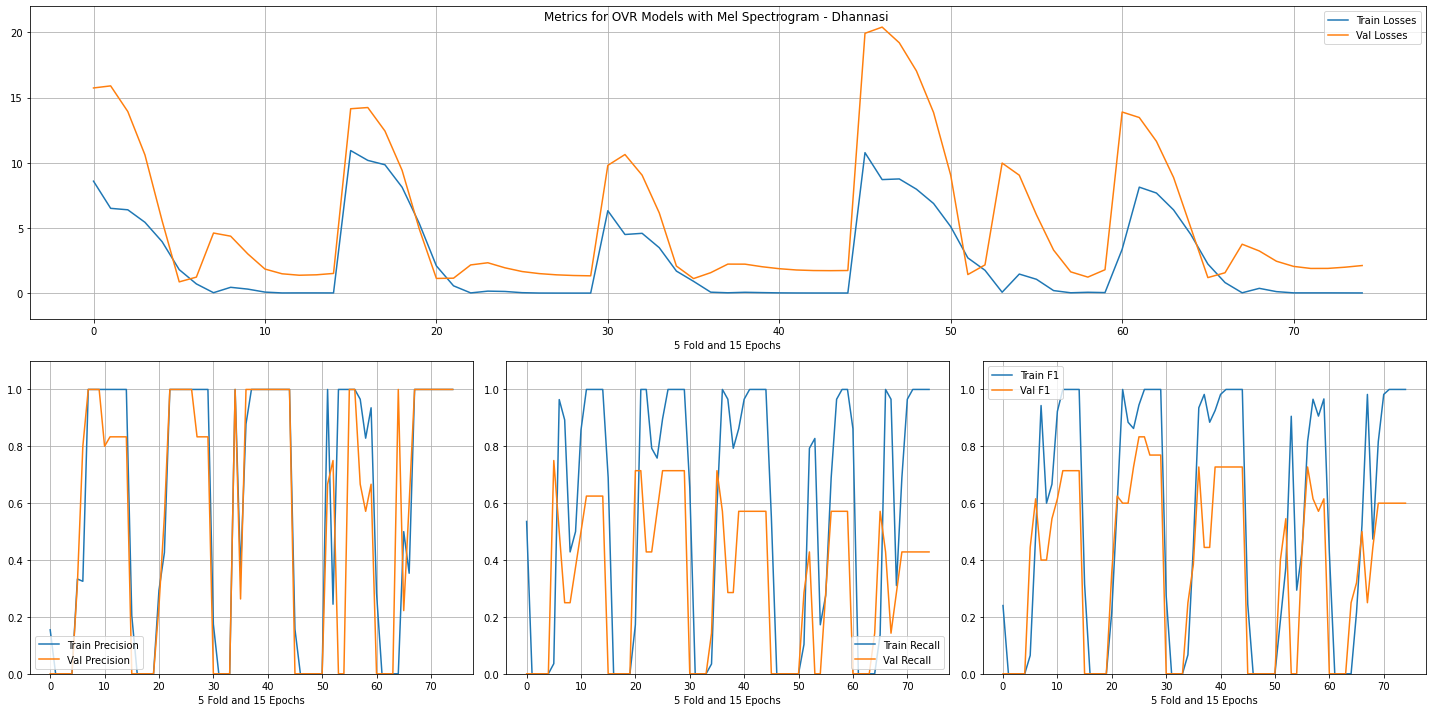

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.833333  ...      0.007450           1.498349
10  0.945455       0.833333  ...      0.035229           1.657371
12  1.000000       0.769231  ...      0.003996           1.404413
13  1.000000       0.769231  ...      0.002542           1.352990
14  1.000000       0.769231  ...      0.002308           1.327078
..       ...            ...  ...           ...                ...
4   0.000000       0.000000  ...      6.877694          13.857332
5   0.000000       0.000000  ...      5.101598           9.049763
1   0.000000       0.000000  ...      8.131438          13.473773
2   0.000000       0.000000  ...      7.679681          11.646389
3   0.000000       0.000000  ...      6.383981           8.872450

[75 rows x 12 columns]
Training for Gowla with 19 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 91/23
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 4.794 / Validation Loss : 9.674 [Time : 0.574

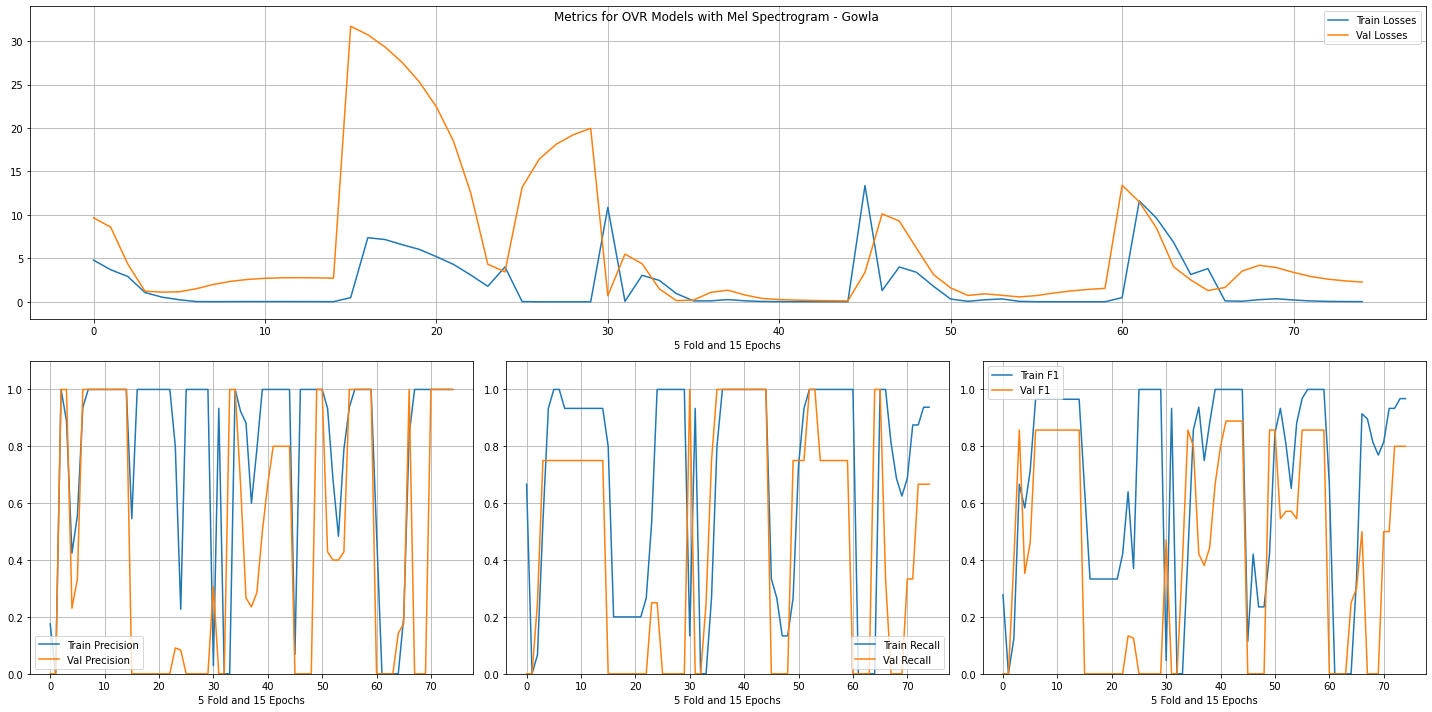

    train_f1  validation_f1  ...  train_losses  validation_losses
11       1.0       0.888889  ...      0.016648           0.193324
12       1.0       0.888889  ...      0.014349           0.151396
13       1.0       0.888889  ...      0.012271           0.123353
14       1.0       0.888889  ...      0.011461           0.104099
11       1.0       0.857143  ...      0.010855           1.010540
..       ...            ...  ...           ...                ...
1        0.0       0.000000  ...      3.695888           8.598712
2        0.0       0.000000  ...      3.048121           4.377358
1        0.0       0.000000  ...     11.605800          11.497370
2        0.0       0.000000  ...      9.641779           8.496557
3        0.0       0.000000  ...      6.846323           4.034643

[75 rows x 12 columns]
Training for Gujjari with 24 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 115/29
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 12.462 / Validation Loss : 7.081 [Time : 0

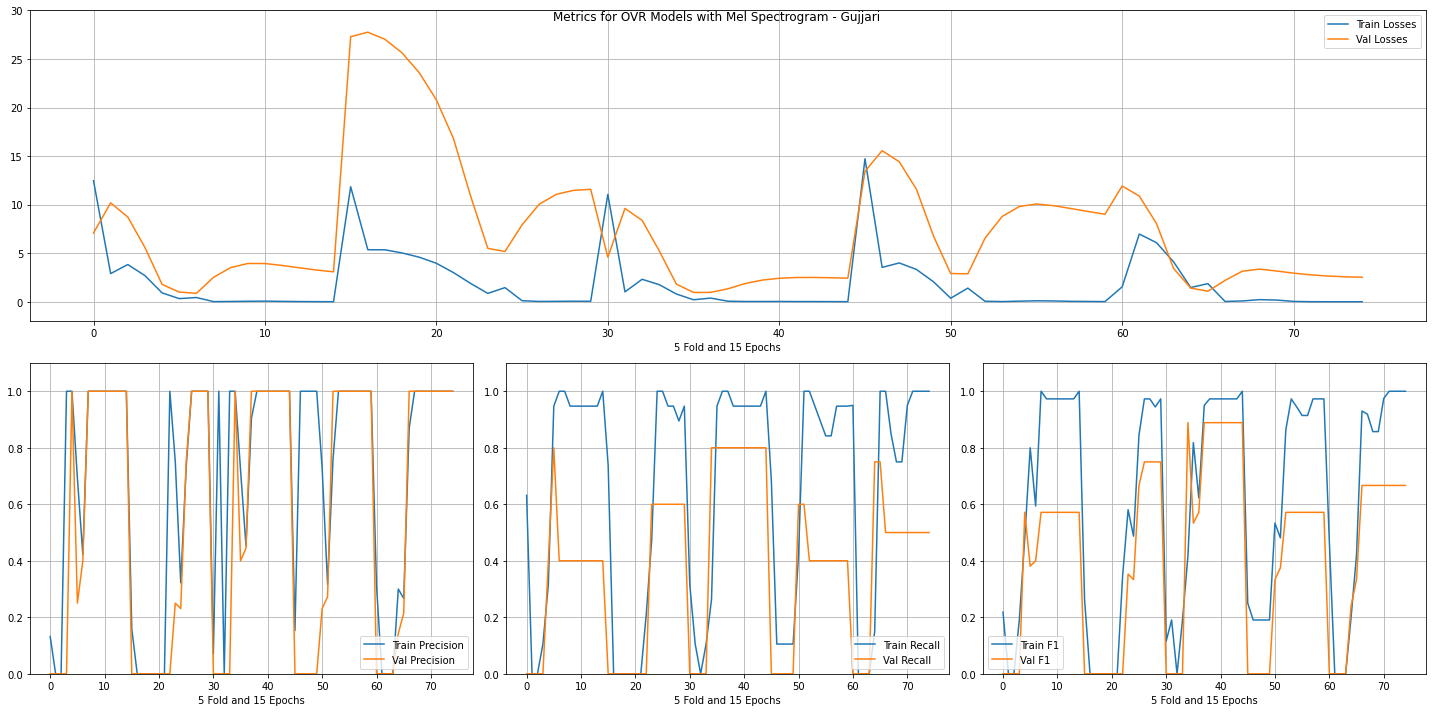

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.888889  ...      0.011827           2.431142
8   0.972973       0.888889  ...      0.029681           1.872904
9   0.972973       0.888889  ...      0.028595           2.230400
10  0.972973       0.888889  ...      0.032592           2.421456
11  0.972973       0.888889  ...      0.023302           2.498145
..       ...            ...  ...           ...                ...
6   0.000000       0.000000  ...      2.998220          16.785200
2   0.000000       0.000000  ...      2.315784           8.381553
1   0.000000       0.000000  ...      6.968819          10.885938
2   0.000000       0.000000  ...      6.090101           8.061500
3   0.000000       0.000000  ...      4.118183           3.430899

[75 rows x 12 columns]
Training for Gundukriya with 10 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 48/12
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 5.738 / Validation Loss : 2.161 [Time : 

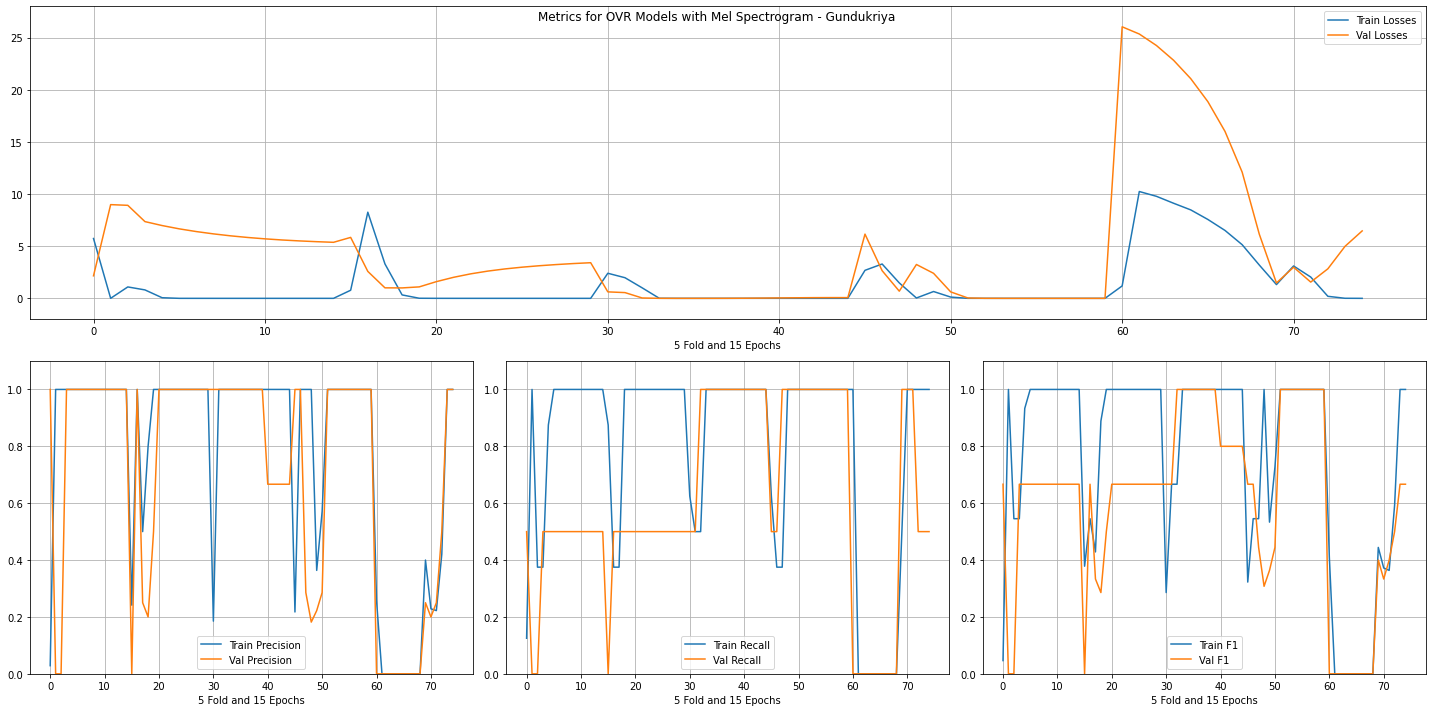

    train_f1  validation_f1  ...  train_losses  validation_losses
3        1.0            1.0  ...      0.007578           0.001781
4        1.0            1.0  ...      0.001188           0.000460
5        1.0            1.0  ...      0.001146           0.000628
6        1.0            1.0  ...      0.001214           0.001421
7        1.0            1.0  ...      0.001581           0.003949
..       ...            ...  ...           ...                ...
4        0.0            0.0  ...      8.483986          21.072918
5        0.0            0.0  ...      7.565794          18.863659
6        0.0            0.0  ...      6.511935          16.009287
7        0.0            0.0  ...      5.145863          12.103731
8        0.0            0.0  ...      3.194477           6.149564

[75 rows x 12 columns]
Training for Kambodhi with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 216/54
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 8.506 / Validation Loss : 12.607 [Time : 

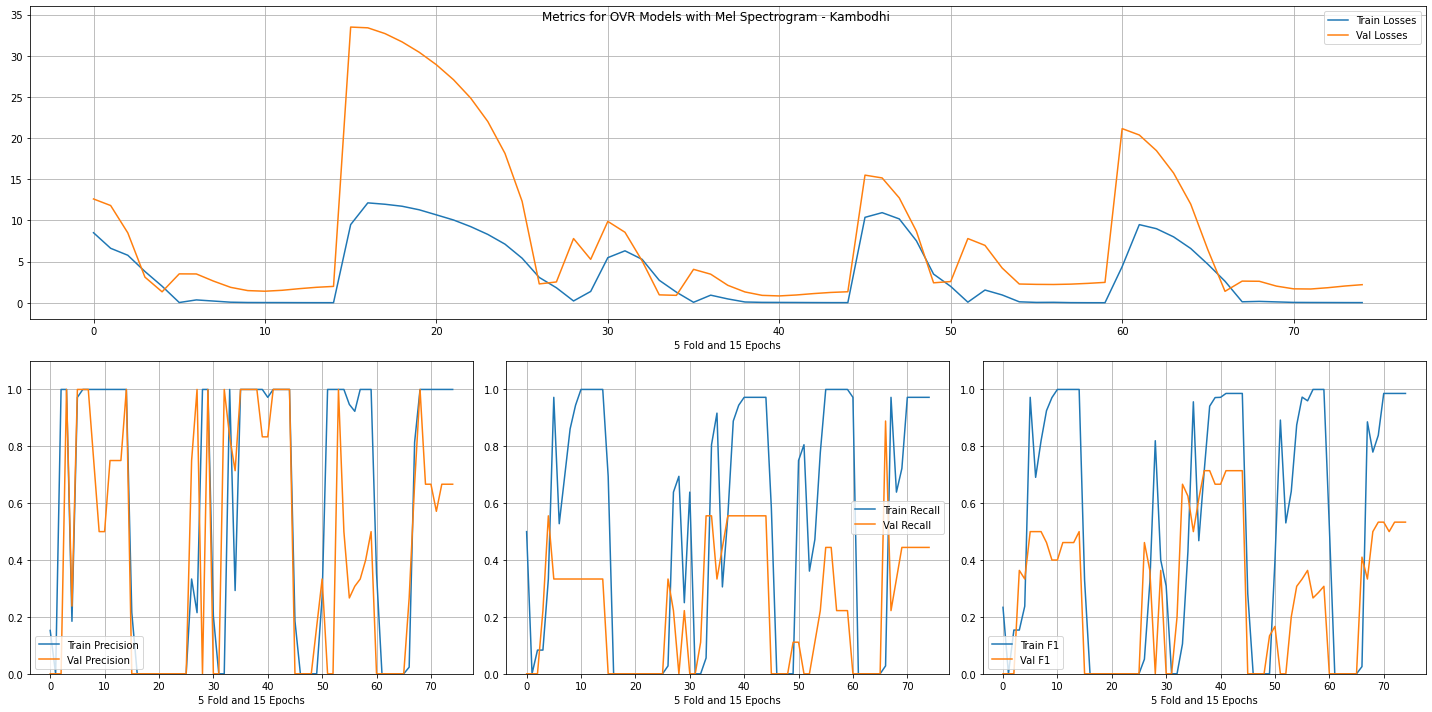

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.985915       0.714286  ...      0.030871           0.942279
12  0.985915       0.714286  ...      0.021101           1.111641
13  0.985915       0.714286  ...      0.014943           1.250431
14  0.985915       0.714286  ...      0.013924           1.334525
8   0.941176       0.714286  ...      0.090351           1.310512
..       ...            ...  ...           ...                ...
1   0.000000       0.000000  ...      9.489466          20.377537
2   0.000000       0.000000  ...      8.994146          18.478786
3   0.000000       0.000000  ...      8.002540          15.756457
4   0.000000       0.000000  ...      6.590019          11.979506
5   0.000000       0.000000  ...      4.674222           6.429846

[75 rows x 12 columns]
Training for Kannadagowla with 65 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 312/78
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 9.462 / Validation Loss : 25.454 [Tim

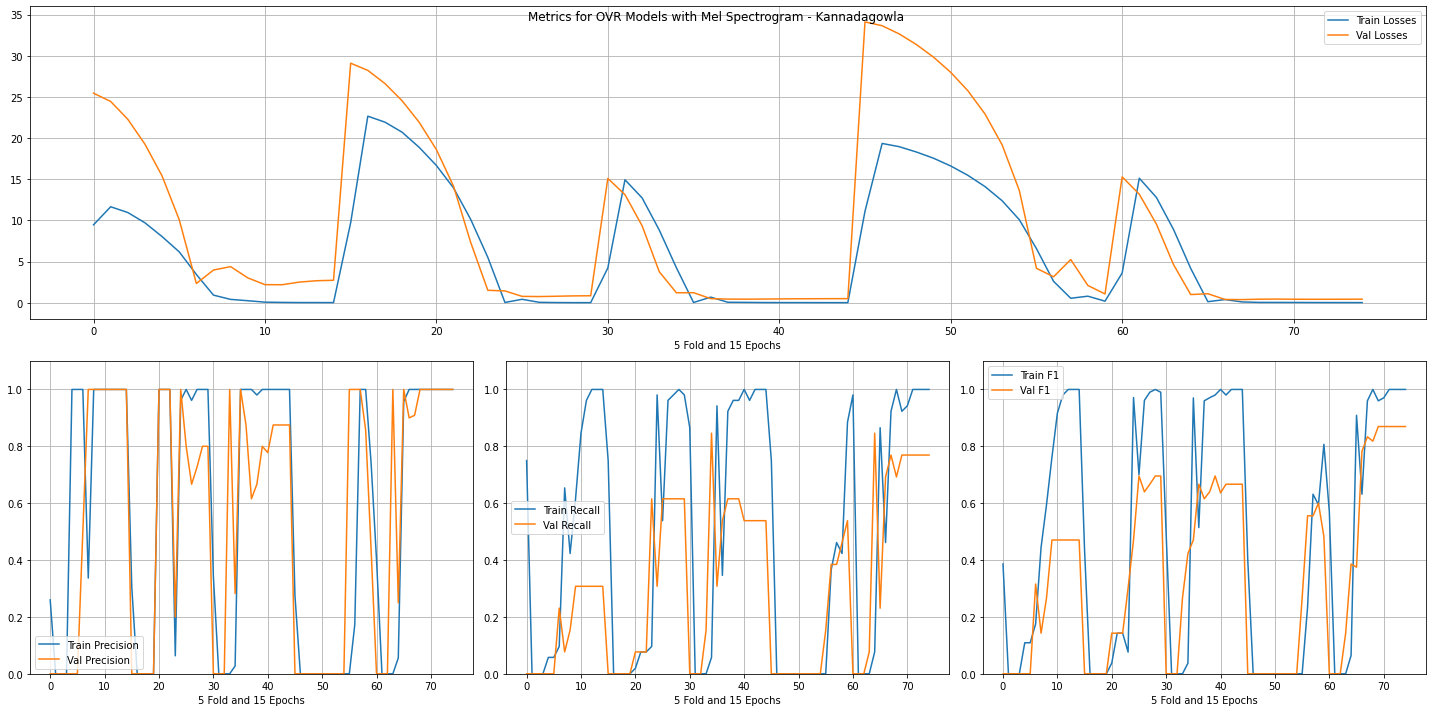

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.869565  ...      0.027309           0.419858
12  1.000000       0.869565  ...      0.022983           0.422139
13  1.000000       0.869565  ...      0.020527           0.426506
14  1.000000       0.869565  ...      0.018038           0.433295
10  0.970297       0.869565  ...      0.034780           0.425409
..       ...            ...  ...           ...                ...
7   0.000000       0.000000  ...     14.110352          22.934186
8   0.000000       0.000000  ...     12.391130          19.176480
9   0.000000       0.000000  ...     10.090531          13.649941
1   0.000000       0.000000  ...     15.128174          13.182294
2   0.000000       0.000000  ...     12.789265           9.543340

[75 rows x 12 columns]
Training for Lalitha with 12 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 57/15
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 8.829 / Validation Loss : 1.866 [Time : 0.4

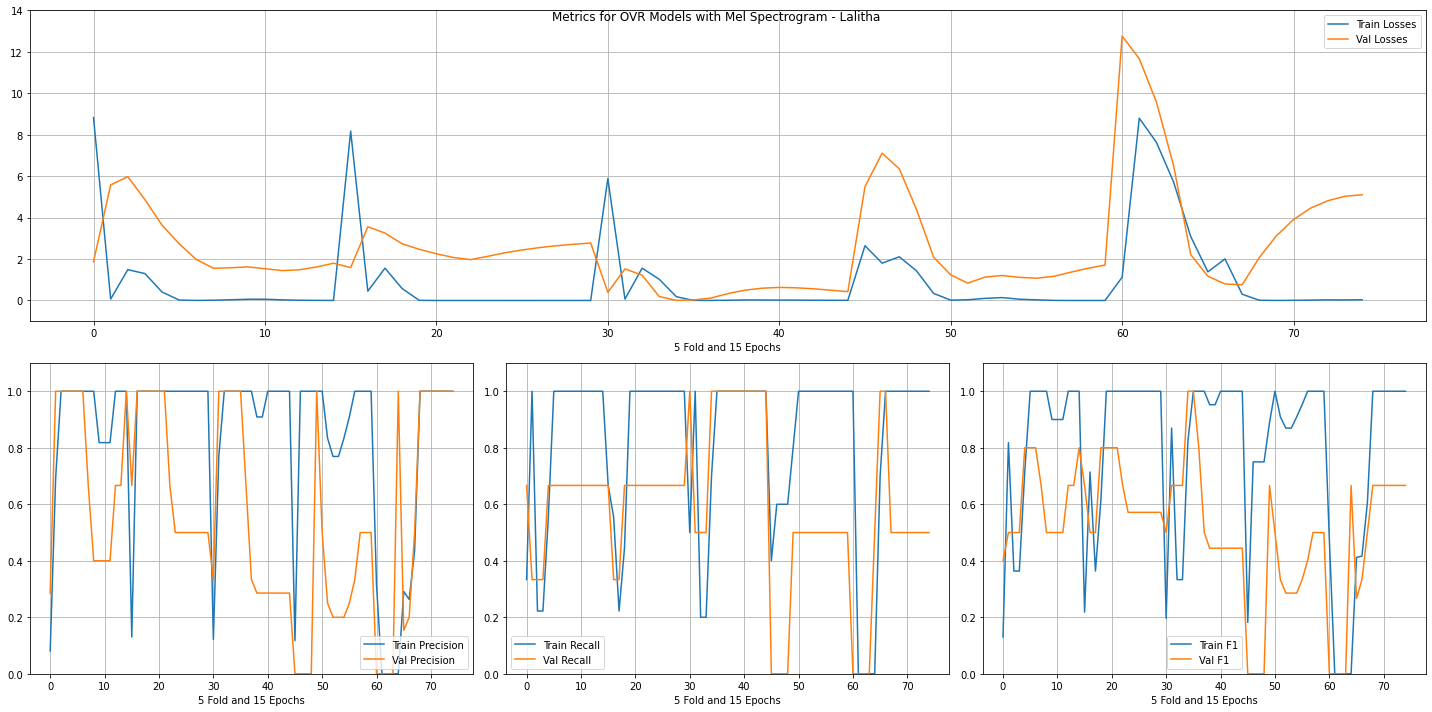

    train_f1  validation_f1  ...  train_losses  validation_losses
5   1.000000            1.0  ...      0.004697           0.026118
4   0.823529            1.0  ...      0.180890           0.004518
5   1.000000            0.8  ...      0.020452           2.734552
6   1.000000            0.8  ...      0.003481           1.974913
14  1.000000            0.8  ...      0.002967           1.798619
..       ...            ...  ...           ...                ...
0   0.476190            0.0  ...      1.122274          12.761277
0   0.181818            0.0  ...      2.642081           5.497014
1   0.000000            0.0  ...      8.797553          11.665943
2   0.000000            0.0  ...      7.629918           9.574162
3   0.000000            0.0  ...      5.717773           6.511155

[75 rows x 12 columns]
Training for Maalavi with 30 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 144/36
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 10.625 / Validation Loss : 5.575 [Time : 0

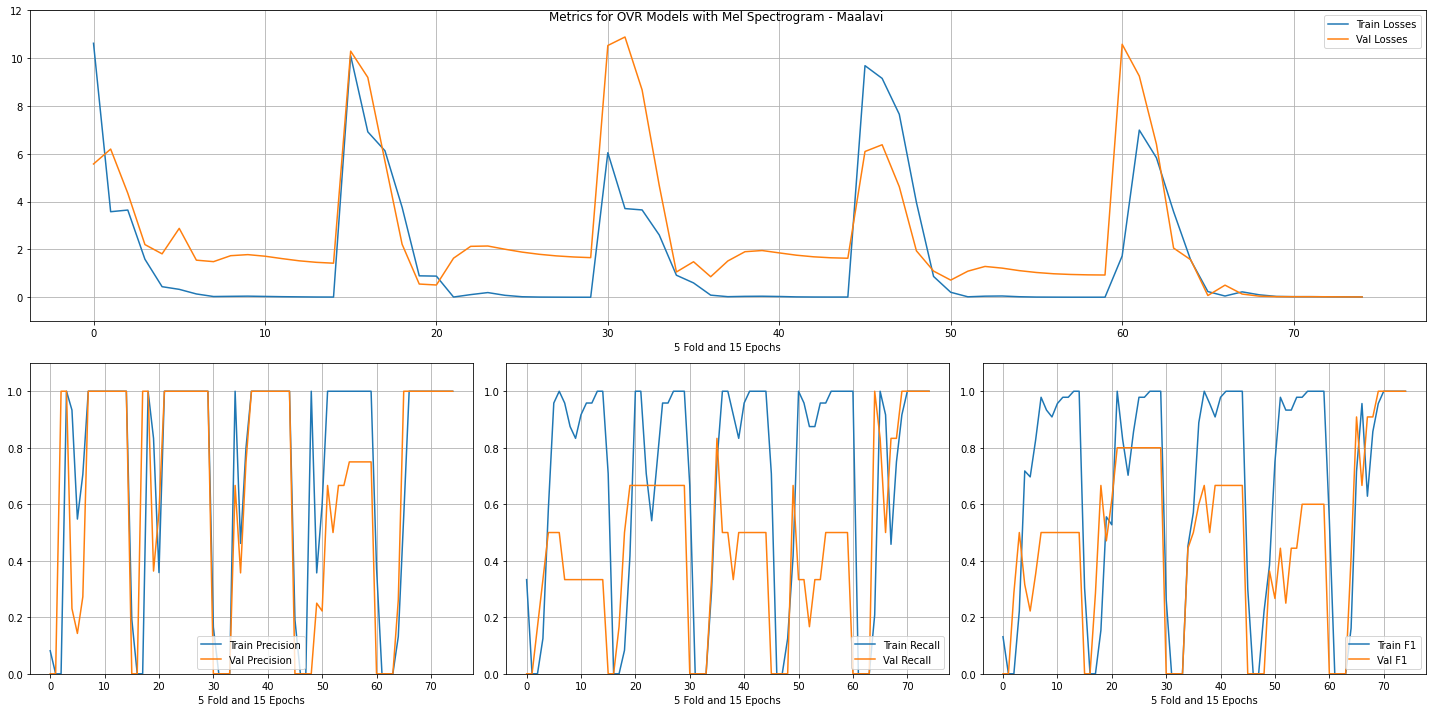

    train_f1  validation_f1  ...  train_losses  validation_losses
10       1.0            1.0  ...      0.026002           0.025032
11       1.0            1.0  ...      0.026084           0.025226
12       1.0            1.0  ...      0.020590           0.021884
13       1.0            1.0  ...      0.017373           0.017634
14       1.0            1.0  ...      0.012806           0.014453
..       ...            ...  ...           ...                ...
1        0.0            0.0  ...      9.155845           6.380165
2        0.0            0.0  ...      7.655910           4.626856
1        0.0            0.0  ...      6.993292           9.252628
2        0.0            0.0  ...      5.834771           6.403433
3        0.0            0.0  ...      3.582249           2.058904

[75 rows x 12 columns]
Training for Malahari with 26 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 124/32
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 11.181 / Validation Loss : 11.988 [Time :

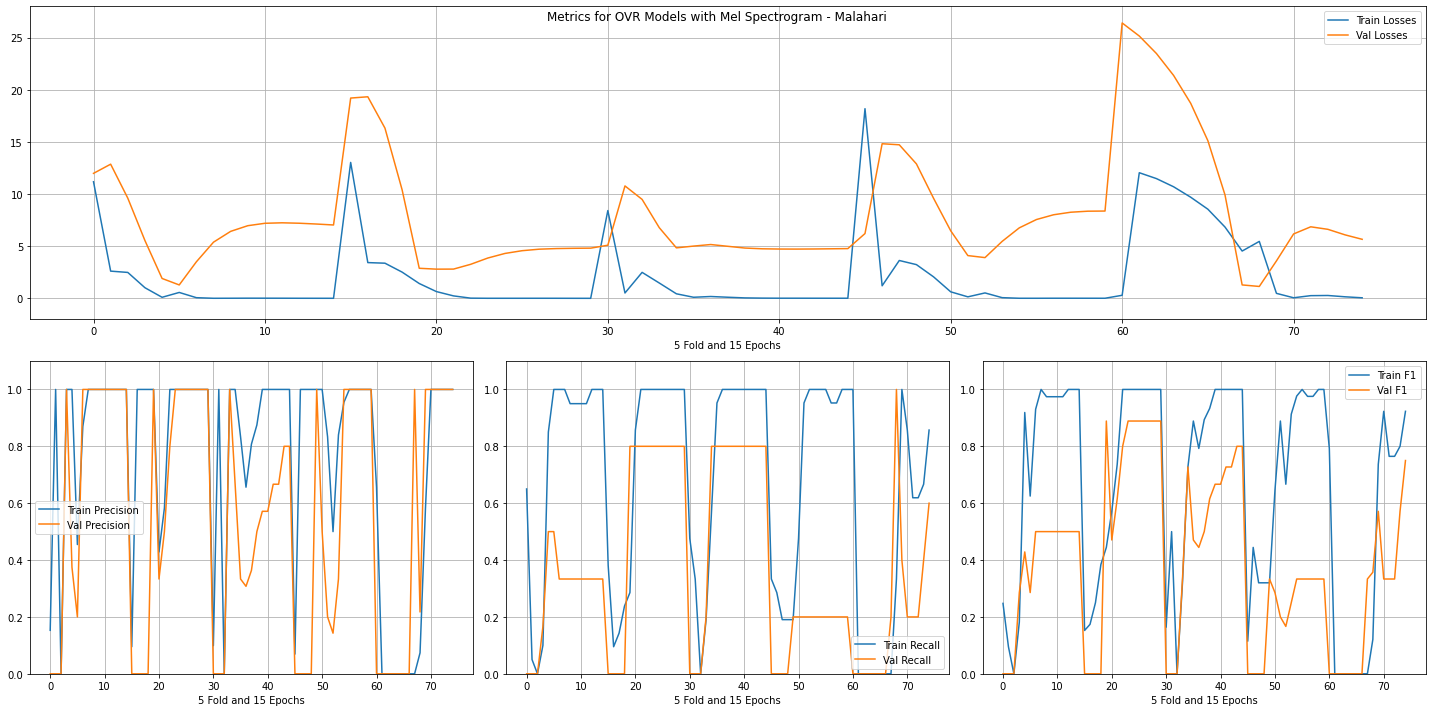

    train_f1  validation_f1  ...  train_losses  validation_losses
8        1.0       0.888889  ...      0.006333           3.866850
9        1.0       0.888889  ...      0.006759           4.306396
10       1.0       0.888889  ...      0.007111           4.569727
11       1.0       0.888889  ...      0.007620           4.715676
12       1.0       0.888889  ...      0.006883           4.774529
..       ...            ...  ...           ...                ...
2        0.0       0.000000  ...     11.484268          23.481941
3        0.0       0.000000  ...     10.701989          21.381039
4        0.0       0.000000  ...      9.697036          18.701733
5        0.0       0.000000  ...      8.549552          15.119722
6        0.0       0.000000  ...      6.836293           9.916667

[75 rows x 12 columns]
Training for Malavigowla with 17 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 81/21
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 12.148 / Validation Loss : 1.435 [Time 

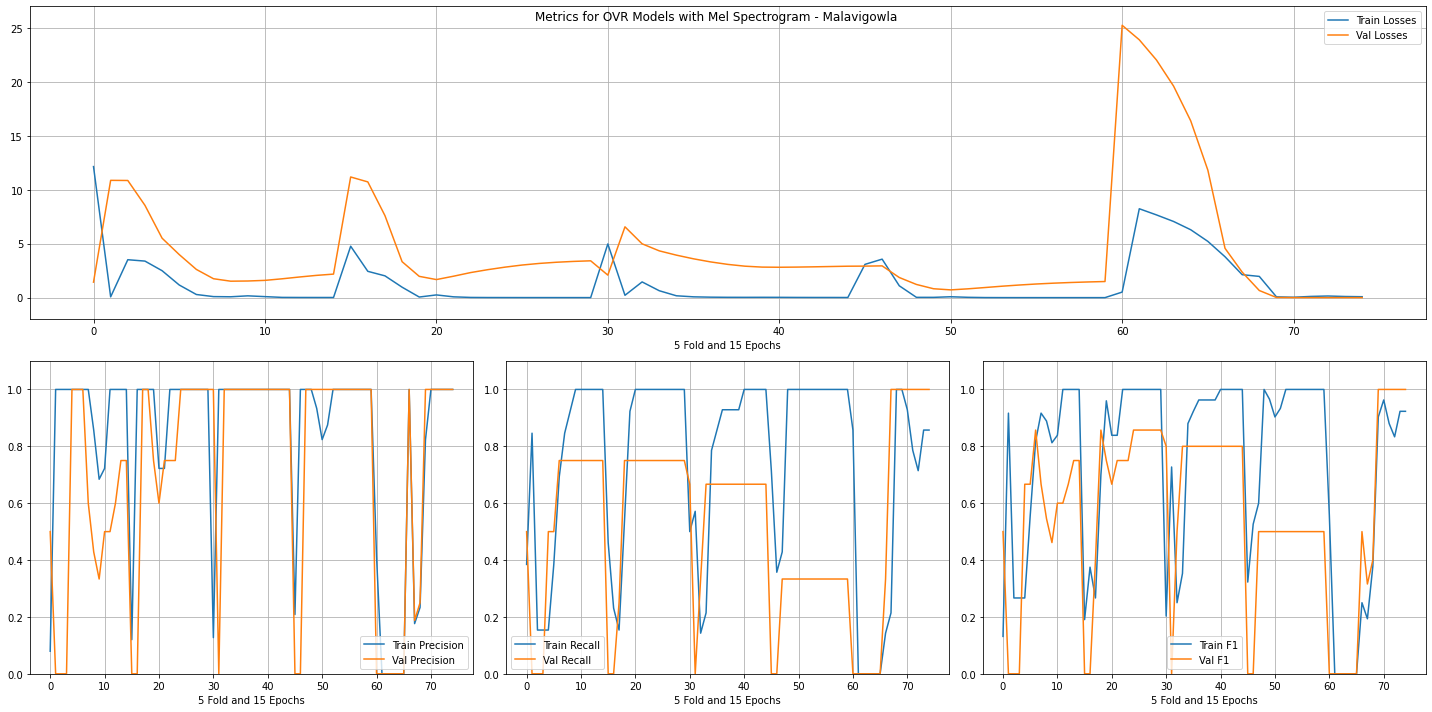

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.962963            1.0  ...      0.036811           0.003360
13  0.923077            1.0  ...      0.104471           0.001069
14  0.923077            1.0  ...      0.084460           0.001055
9   0.903226            1.0  ...      0.070004           0.014328
11  0.880000            1.0  ...      0.111109           0.001604
..       ...            ...  ...           ...                ...
1   0.000000            0.0  ...      8.239759          23.903723
2   0.000000            0.0  ...      7.670084          22.032265
3   0.000000            0.0  ...      7.060034          19.609772
4   0.000000            0.0  ...      6.292980          16.386475
5   0.000000            0.0  ...      5.213105          11.812790

[75 rows x 12 columns]
Training for Mukhari with 14 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 67/17
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 4.221 / Validation Loss : 13.009 [Time : 0.

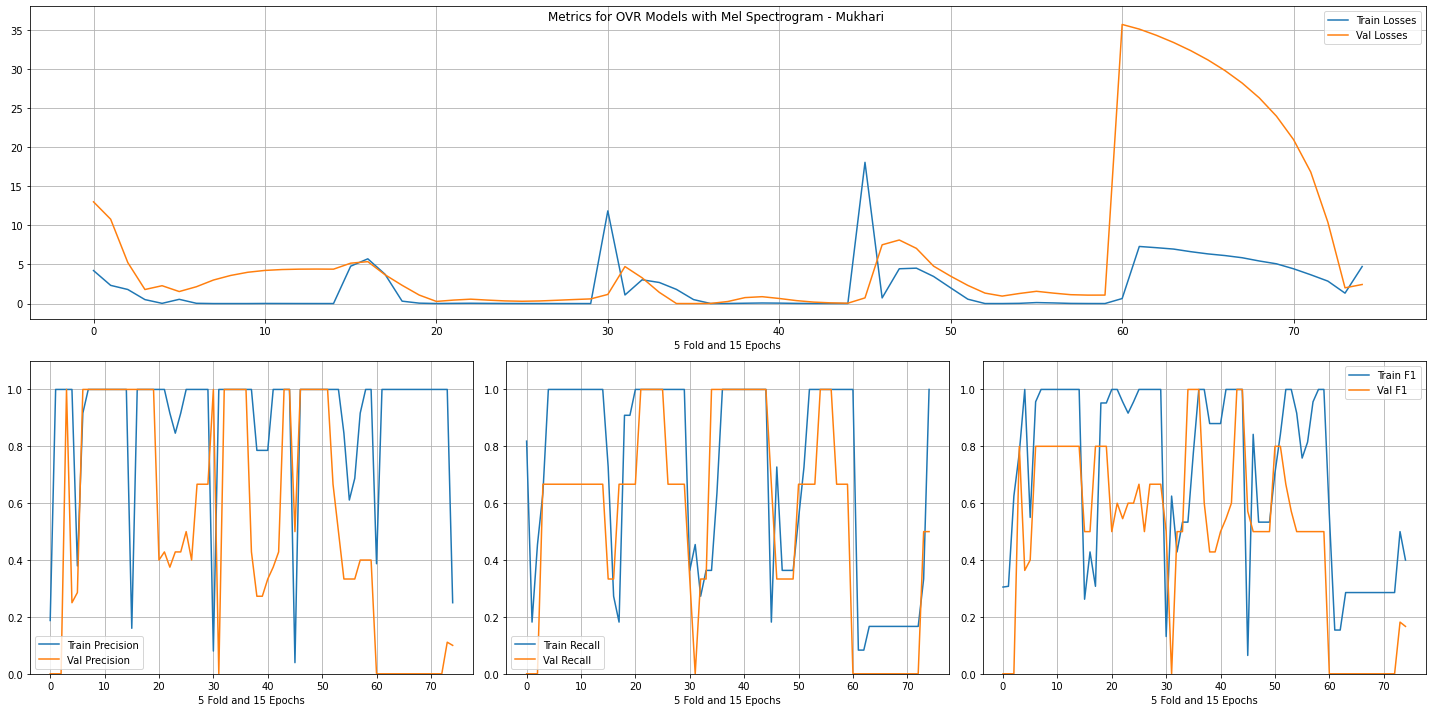

    train_f1  validation_f1  ...  train_losses  validation_losses
6   1.000000            1.0  ...      0.003292           0.016169
13  1.000000            1.0  ...      0.005664           0.089350
14  1.000000            1.0  ...      0.003876           0.045795
5   0.777778            1.0  ...      0.508061           0.000827
4   0.533333            1.0  ...      1.813054           0.004156
..       ...            ...  ...           ...                ...
10  0.285714            0.0  ...      4.444767          20.958437
11  0.285714            0.0  ...      3.682823          16.821878
12  0.285714            0.0  ...      2.868209          10.398365
1   0.153846            0.0  ...      7.301426          35.095413
2   0.153846            0.0  ...      7.143421          34.301235

[75 rows x 12 columns]
Training for Naata with 14 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 67/17
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 5.300 / Validation Loss : 7.120 [Time : 0.537

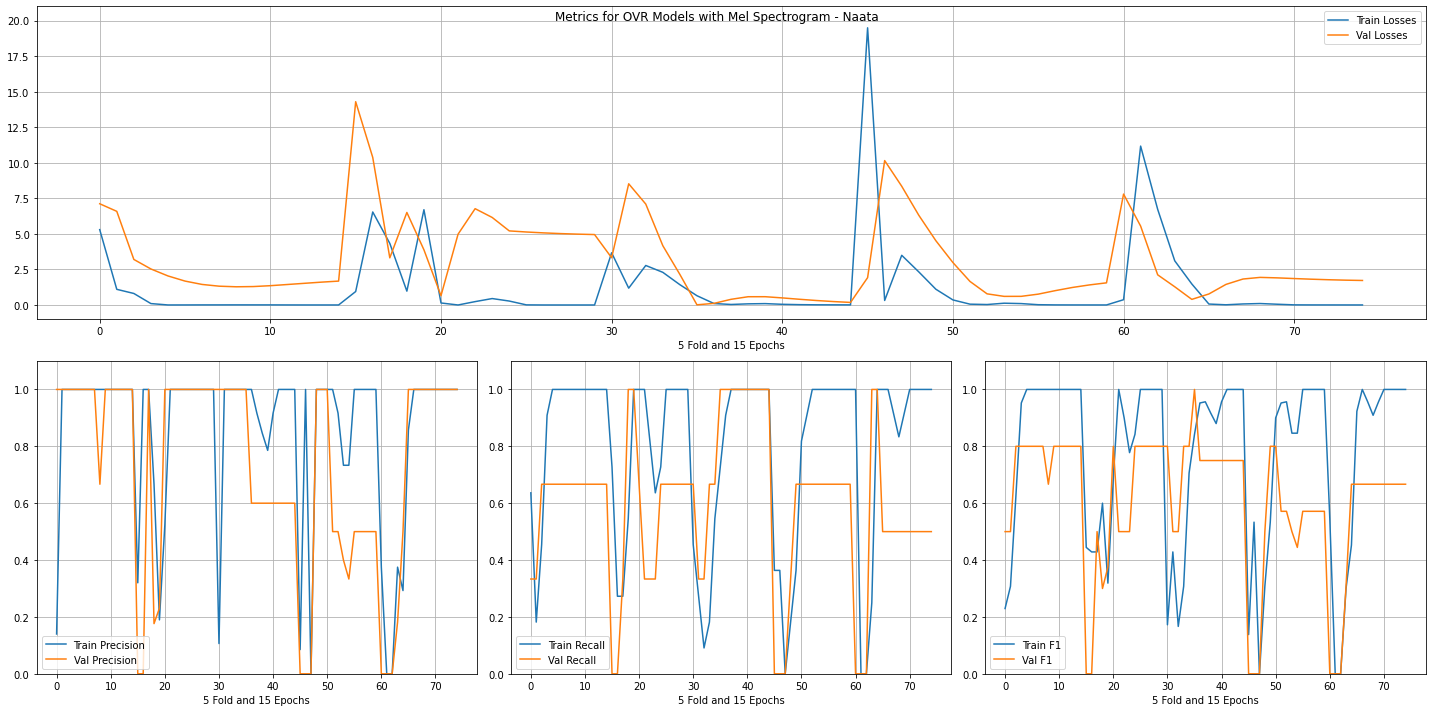

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.842105            1.0  ...      0.651503           0.012231
4   1.000000            0.8  ...      0.001639           2.042750
5   1.000000            0.8  ...      0.002747           1.680689
6   1.000000            0.8  ...      0.005790           1.444688
7   1.000000            0.8  ...      0.006395           1.321929
..       ...            ...  ...           ...                ...
1   0.428571            0.0  ...      6.541041          10.379343
0   0.137931            0.0  ...     19.493977           1.921909
2   0.000000            0.0  ...      3.494012           8.349322
1   0.000000            0.0  ...     11.174668           5.548576
2   0.000000            0.0  ...      6.724331           2.120509

[75 rows x 12 columns]
Training for Nadaramakriya with 51 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 244/62
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 7.627 / Validation Loss : 28.880 [Ti

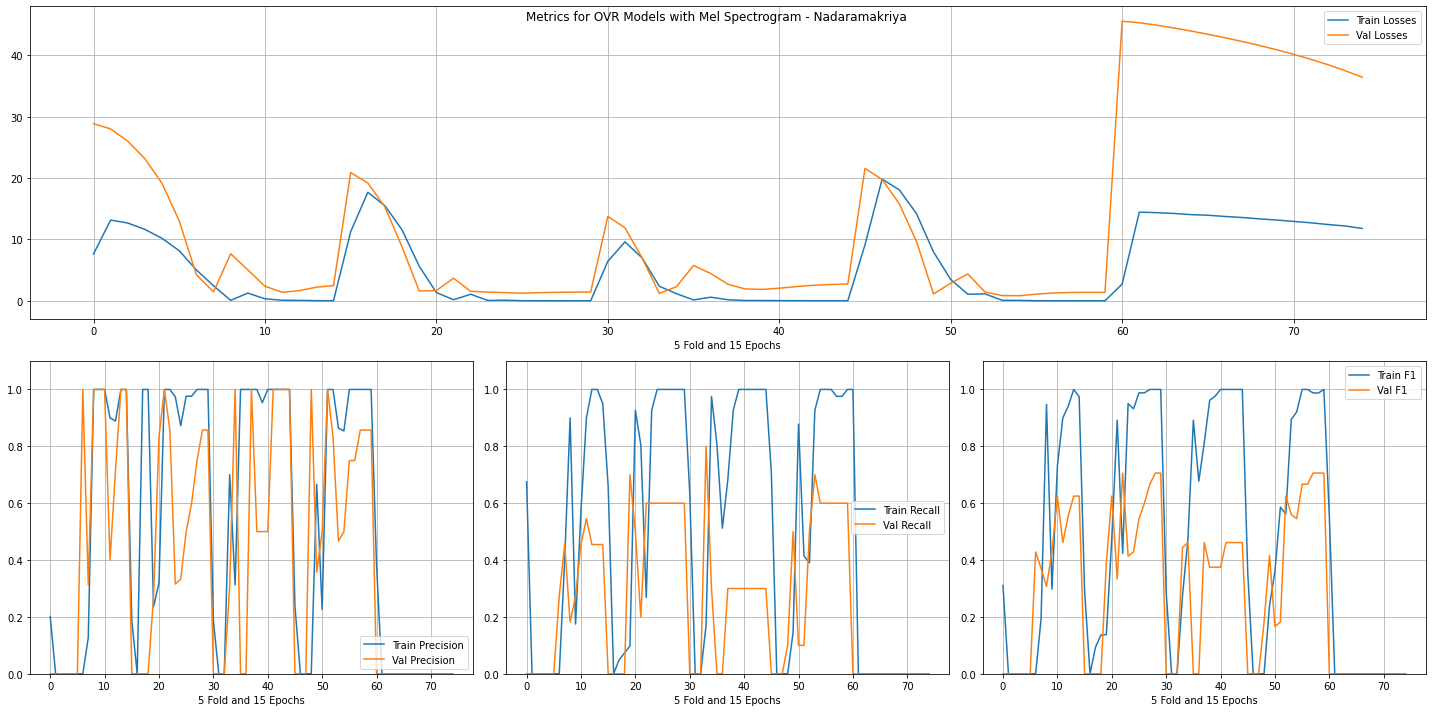

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.705882  ...      0.007166           1.414053
14  1.000000       0.705882  ...      0.006184           1.425967
14  1.000000       0.705882  ...      0.005958           1.380253
12  0.987654       0.705882  ...      0.007573           1.358262
13  0.987654       0.705882  ...      0.008098           1.379588
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...     12.945242          40.193452
11  0.000000       0.000000  ...     12.717458          39.382933
12  0.000000       0.000000  ...     12.437150          38.499470
13  0.000000       0.000000  ...     12.200721          37.530760
14  0.000000       0.000000  ...     11.792013          36.457548

[75 rows x 12 columns]
Training for Paadi with 54 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 259/65
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 5.886 / Validation Loss : 17.489 [Time : 1.0

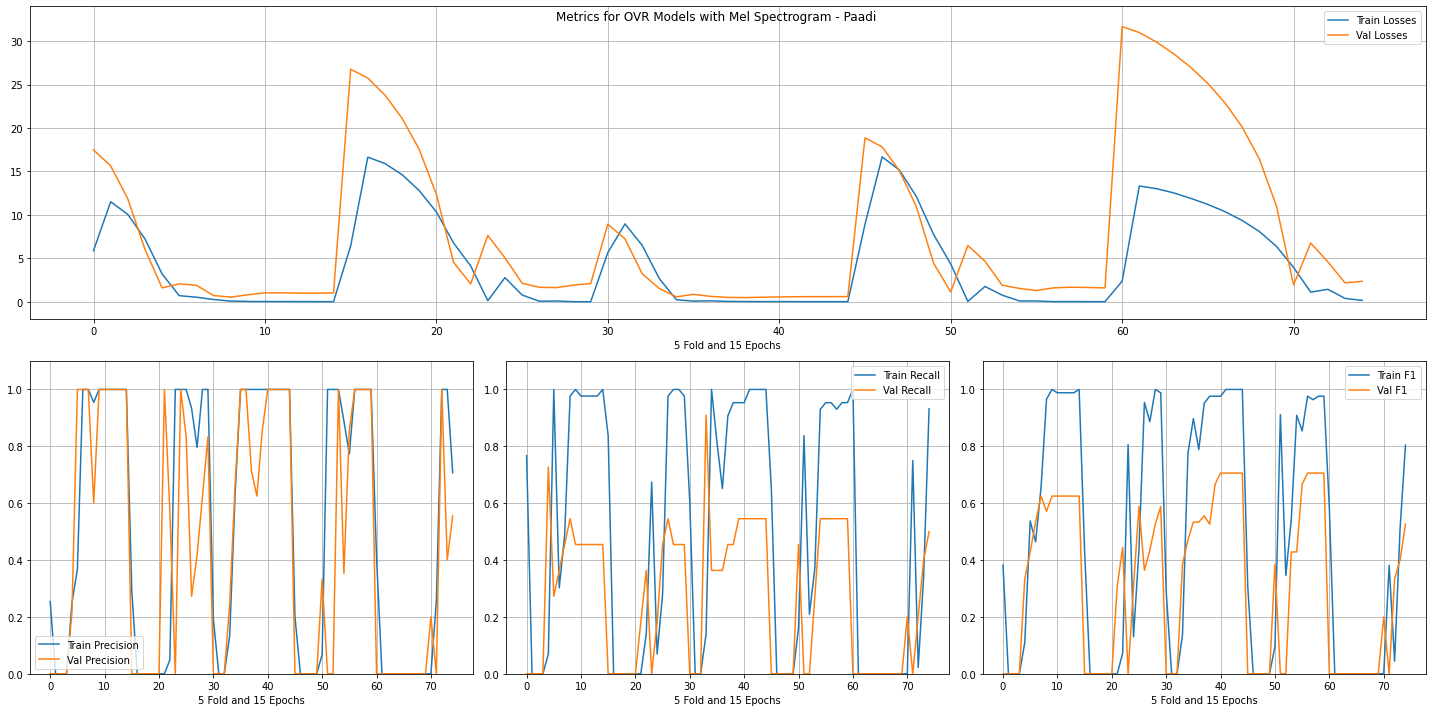

    train_f1  validation_f1  ...  train_losses  validation_losses
11   1.00000       0.705882  ...      0.020510           0.588468
12   1.00000       0.705882  ...      0.018562           0.596376
13   1.00000       0.705882  ...      0.017379           0.596762
14   1.00000       0.705882  ...      0.015050           0.603383
10   0.97619       0.705882  ...      0.024770           0.563285
..       ...            ...  ...           ...                ...
5    0.00000       0.000000  ...     11.206521          25.131170
6    0.00000       0.000000  ...     10.376128          22.890069
7    0.00000       0.000000  ...      9.363889          20.117934
8    0.00000       0.000000  ...      8.097036          16.452433
9    0.00000       0.000000  ...      6.386328          11.028165

[75 rows x 12 columns]
Training for Ramakriya with 88 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 422/106
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 7.897 / Validation Loss : 12.795 [Time 

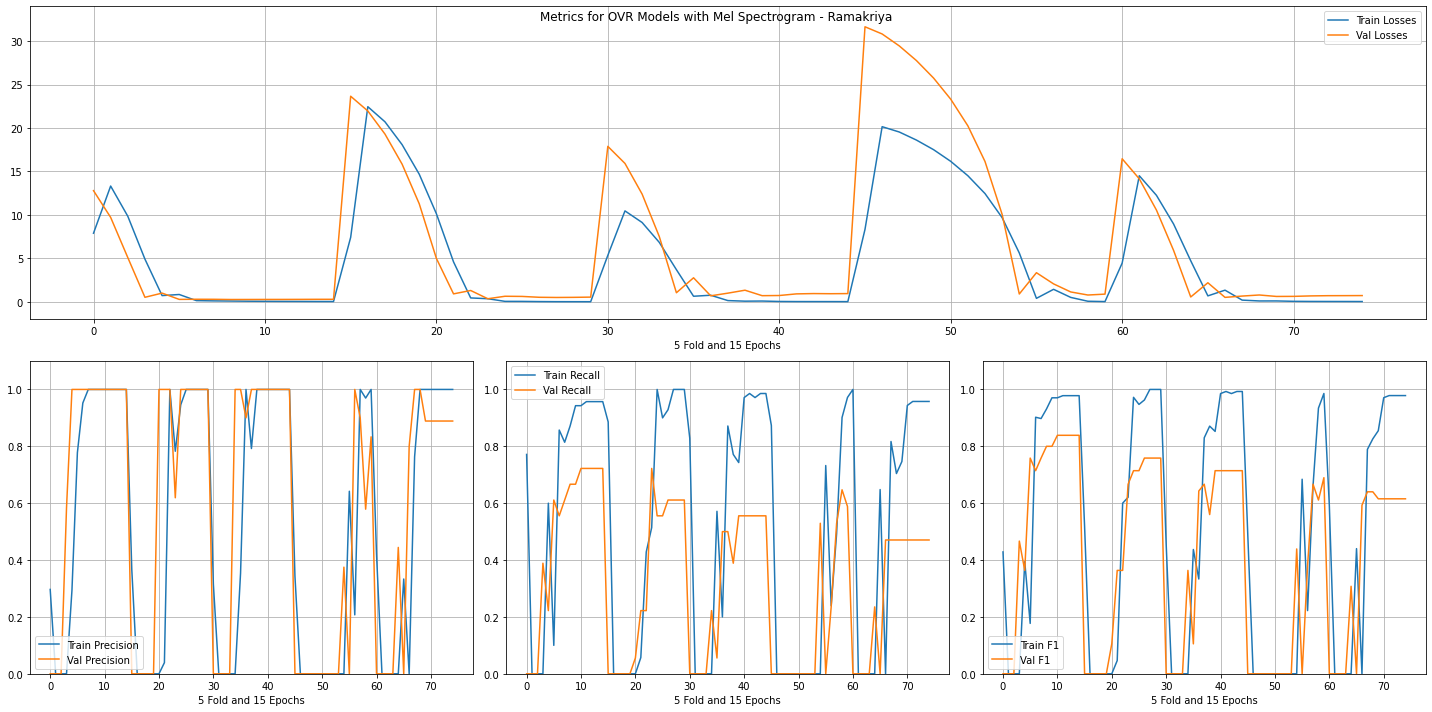

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.978102        0.83871  ...      0.051167           0.275564
12  0.978102        0.83871  ...      0.045768           0.280728
13  0.978102        0.83871  ...      0.037937           0.288670
14  0.978102        0.83871  ...      0.034732           0.290374
10  0.970588        0.83871  ...      0.059312           0.273764
..       ...            ...  ...           ...                ...
7   0.000000        0.00000  ...     12.460154          16.150830
8   0.000000        0.00000  ...      9.687597          10.056326
1   0.000000        0.00000  ...     14.509805          14.154484
2   0.000000        0.00000  ...     12.256808          10.559700
3   0.000000        0.00000  ...      8.954162           5.917964

[75 rows x 12 columns]
Training for Salangam with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 96/24
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 12.440 / Validation Loss : 0.402 [Time : 0

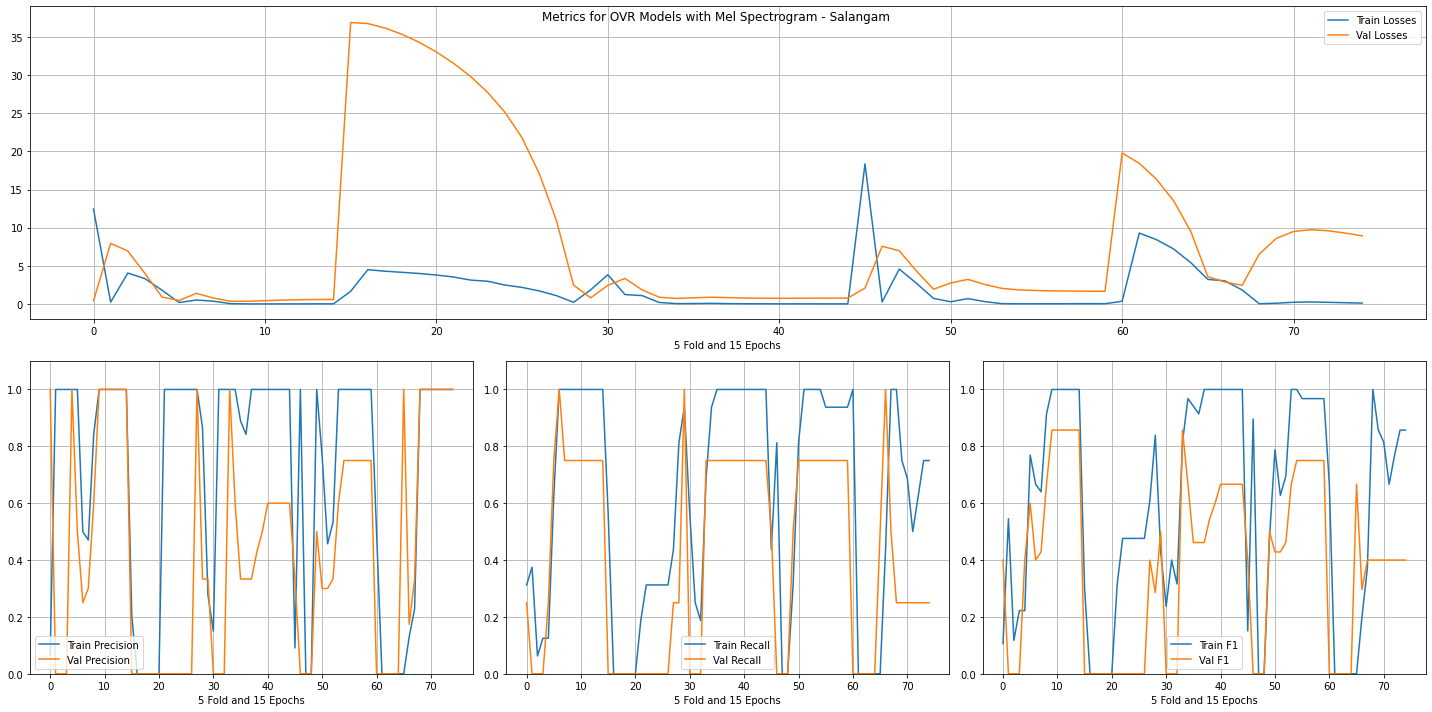

    train_f1  validation_f1  ...  train_losses  validation_losses
9        1.0       0.857143  ...      0.005313           0.345804
10       1.0       0.857143  ...      0.002580           0.428944
11       1.0       0.857143  ...      0.003989           0.498570
12       1.0       0.857143  ...      0.007358           0.552089
13       1.0       0.857143  ...      0.012060           0.582092
..       ...            ...  ...           ...                ...
3        0.0       0.000000  ...      2.706098           4.320212
1        0.0       0.000000  ...      9.295548          18.427528
2        0.0       0.000000  ...      8.429153          16.350359
3        0.0       0.000000  ...      7.206494          13.531268
4        0.0       0.000000  ...      5.417698           9.528045

[75 rows x 12 columns]
Training for Salanganata with 61 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 292/74
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 6.672 / Validation Loss : 19.662 [Time

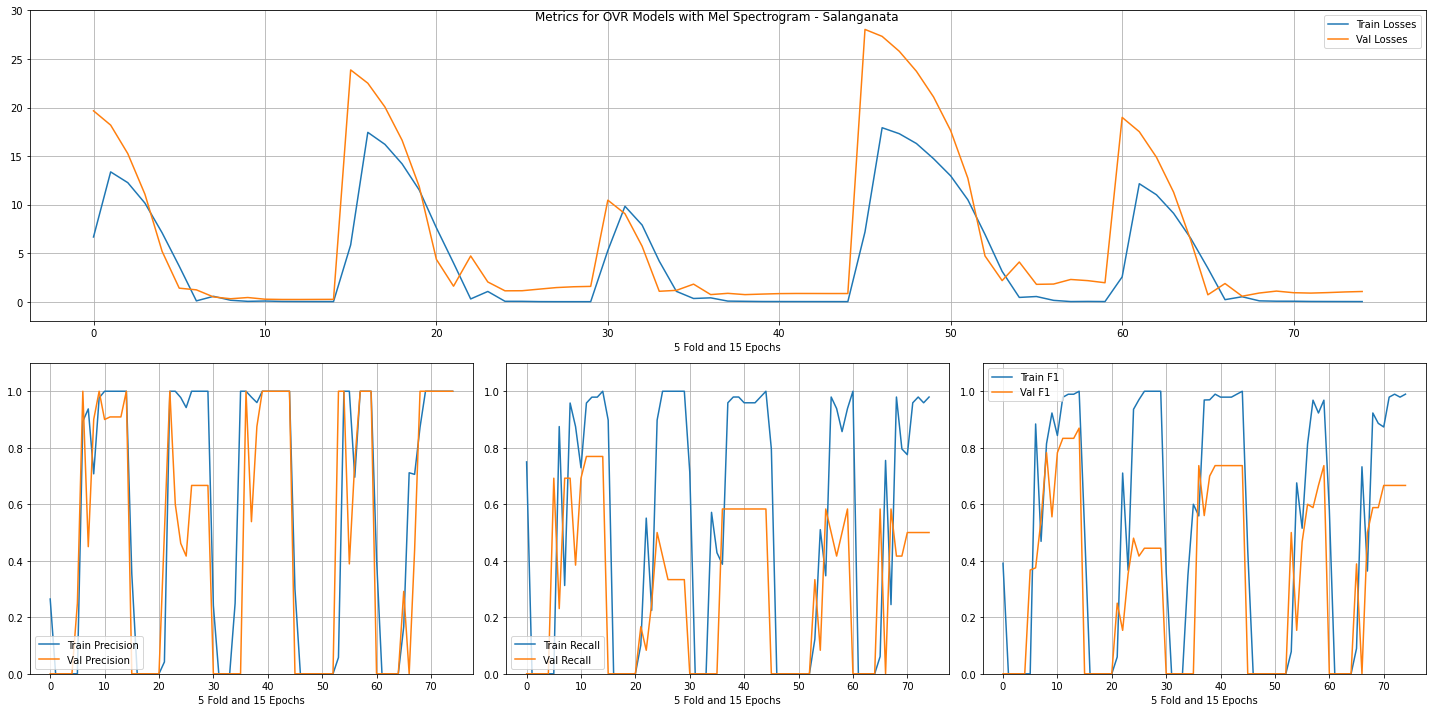

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.869565  ...      0.021393           0.247992
12  0.989474       0.833333  ...      0.029600           0.235469
13  0.989474       0.833333  ...      0.024292           0.241963
11  0.978723       0.833333  ...      0.037173           0.237038
10  0.843373       0.782609  ...      0.077167           0.264752
..       ...            ...  ...           ...                ...
7   0.000000       0.000000  ...      6.937755           4.721212
1   0.000000       0.000000  ...     12.155869          17.511216
2   0.000000       0.000000  ...     11.018873          14.881557
3   0.000000       0.000000  ...      9.108960          11.286298
4   0.000000       0.000000  ...      6.532007           6.335513

[75 rows x 12 columns]
Training for Samantham with 28 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 134/34
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 9.839 / Validation Loss : 5.466 [Time : 

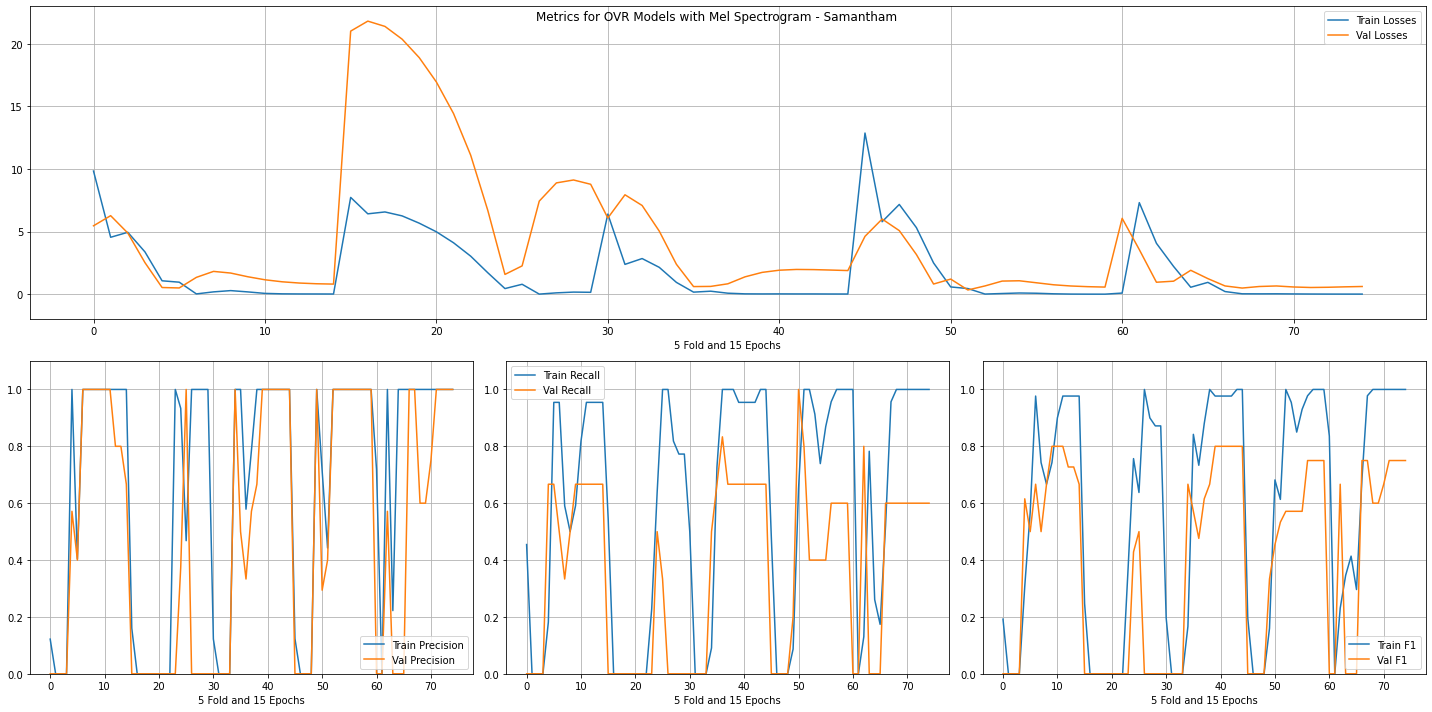

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000            0.8  ...      0.014441           1.927738
14  1.000000            0.8  ...      0.012366           1.887603
11  0.976744            0.8  ...      0.027035           0.990033
9   0.976744            0.8  ...      0.020052           1.741381
10  0.976744            0.8  ...      0.023622           1.915972
..       ...            ...  ...           ...                ...
3   0.000000            0.0  ...      2.144149           5.039439
1   0.000000            0.0  ...      5.791221           6.005027
2   0.000000            0.0  ...      7.171430           5.079769
3   0.000000            0.0  ...      5.315930           3.167563
1   0.000000            0.0  ...      7.315948           3.562896

[75 rows x 12 columns]
Training for Sankarabharanam with 61 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 292/74
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 6.544 / Validation Loss : 16.677 [

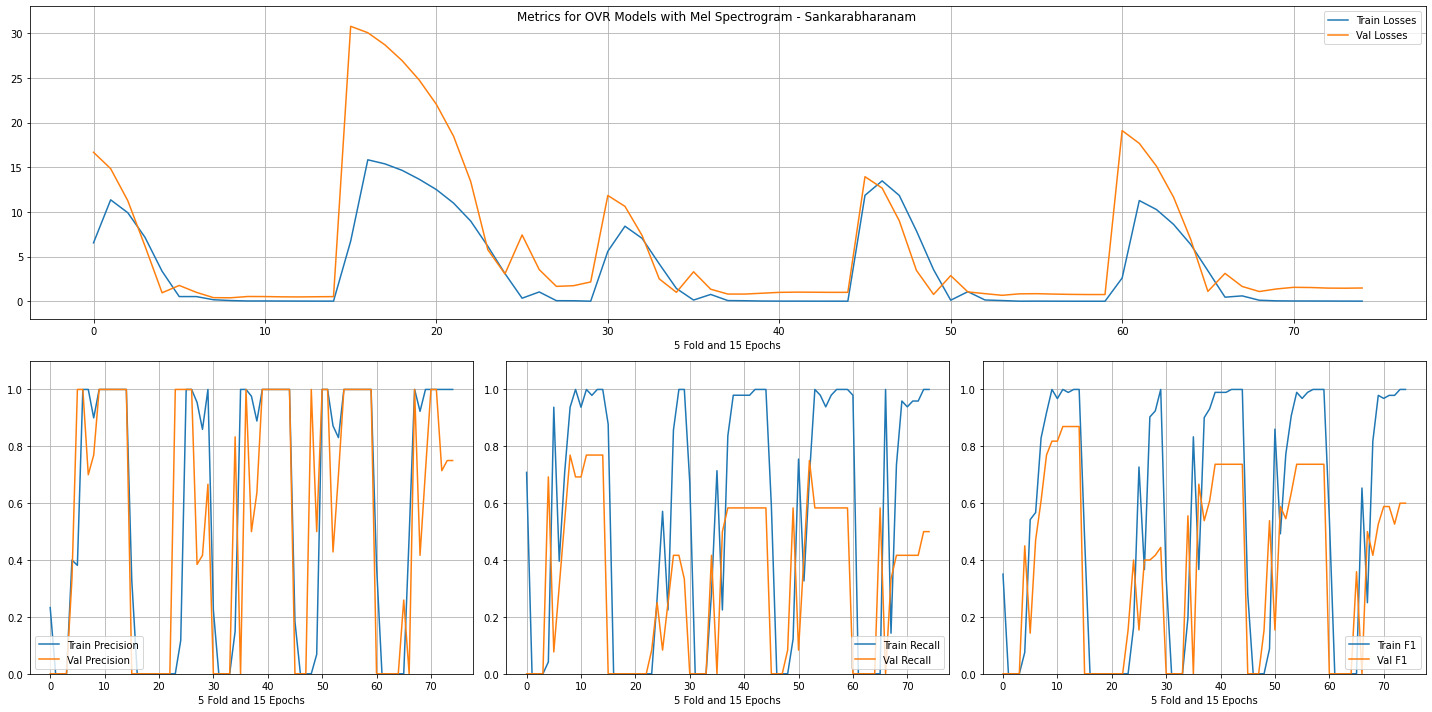

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.869565  ...      0.032149           0.501501
13  1.000000       0.869565  ...      0.022179           0.512433
14  1.000000       0.869565  ...      0.019368           0.526565
12  0.989474       0.869565  ...      0.027586           0.492464
9   1.000000       0.818182  ...      0.037853           0.539976
..       ...            ...  ...           ...                ...
2   0.000000       0.000000  ...     11.846919           9.015588
1   0.000000       0.000000  ...     11.275586          17.673507
2   0.000000       0.000000  ...     10.270571          15.130380
3   0.000000       0.000000  ...      8.608641          11.647596
4   0.000000       0.000000  ...      6.358237           6.926739

[75 rows x 12 columns]
Training for Sriragam with 76 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 364/92
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 9.444 / Validation Loss : 27.541 [Time : 

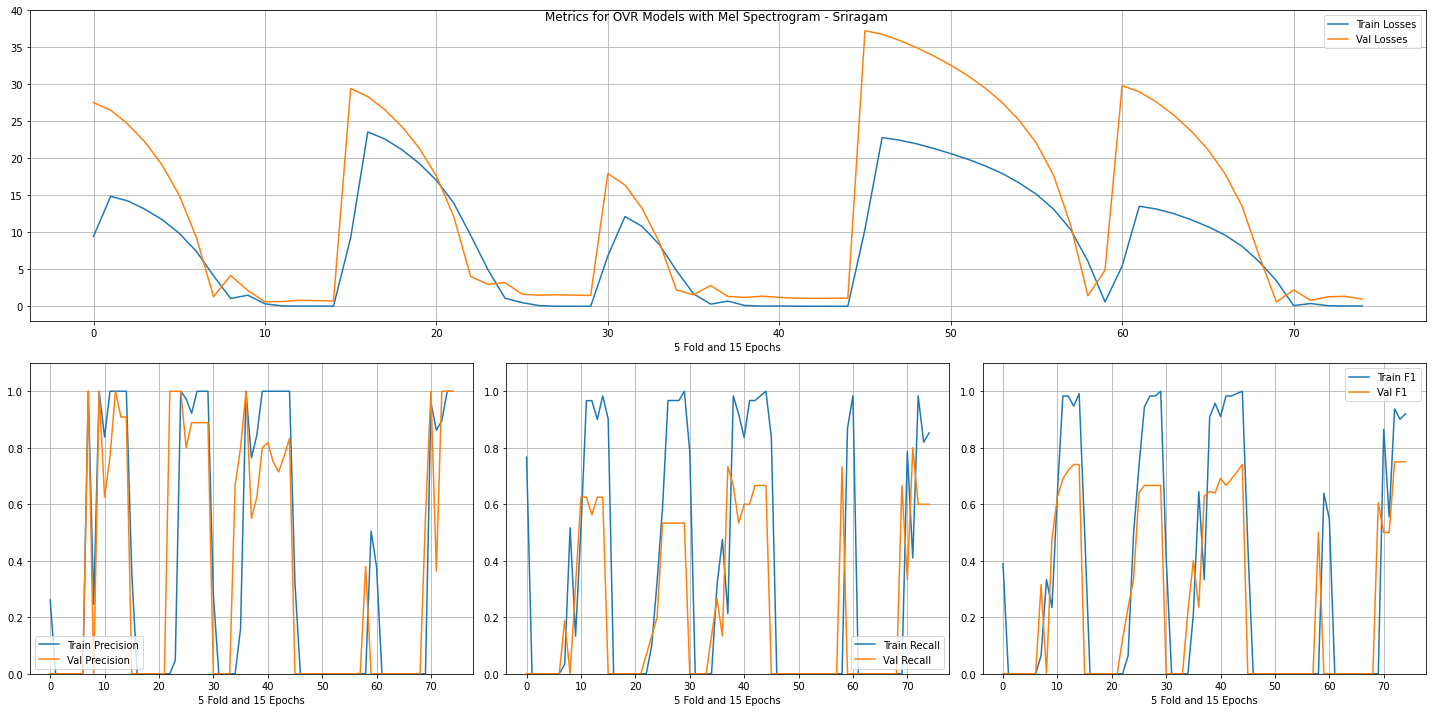

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.937500       0.750000  ...      0.091219           1.294403
14  0.920354       0.750000  ...      0.050960           0.982982
13  0.900901       0.750000  ...      0.059539           1.361298
14  1.000000       0.740741  ...      0.016880           1.114320
14  0.991597       0.740741  ...      0.029518           0.738426
..       ...            ...  ...           ...                ...
4   0.000000       0.000000  ...     11.738414          23.775949
5   0.000000       0.000000  ...     10.779935          21.200970
6   0.000000       0.000000  ...      9.635486          17.930077
7   0.000000       0.000000  ...      8.111513          13.513169
8   0.000000       0.000000  ...      6.026571           6.794325

[75 rows x 12 columns]
Training for Suddavasantham with 10 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 48/12
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 1.511 / Validation Loss : 1.944 [Tim

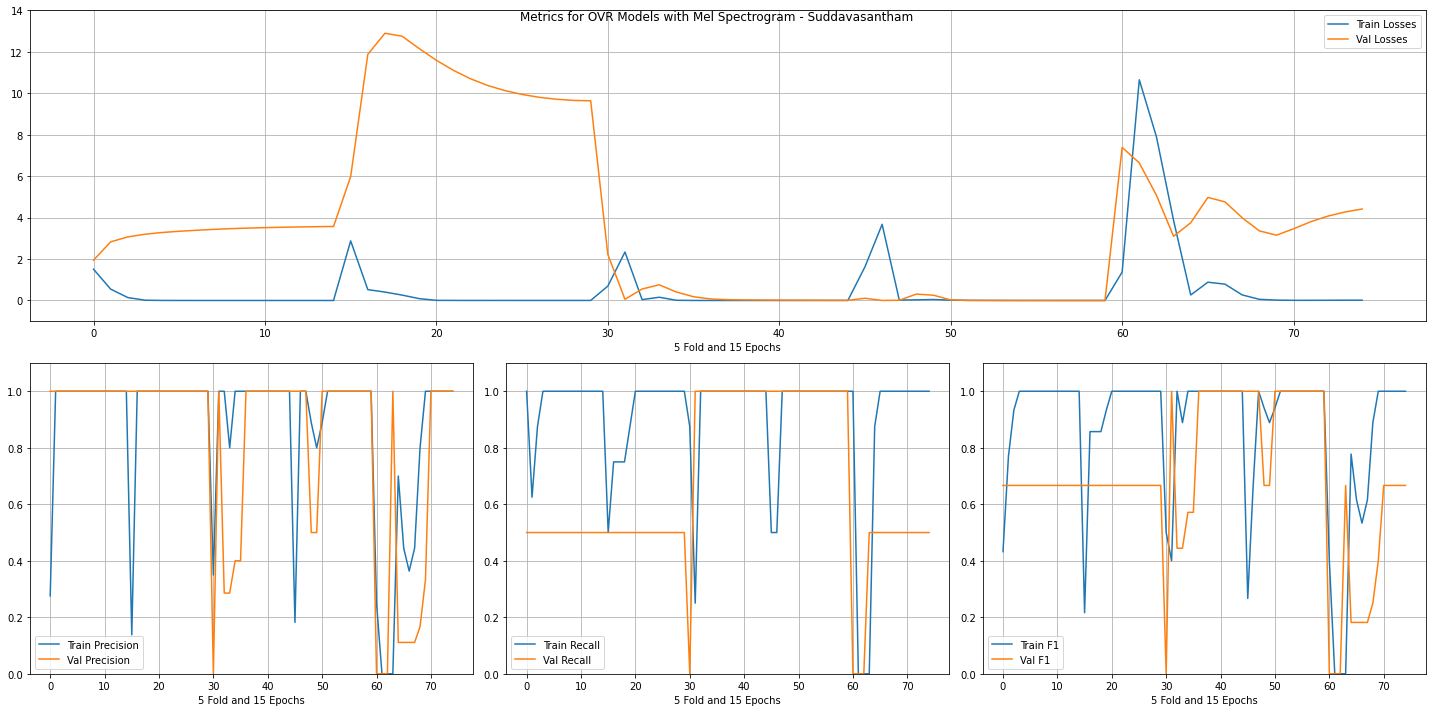

    train_f1  validation_f1  ...  train_losses  validation_losses
6   1.000000       1.000000  ...      0.000159           0.073310
7   1.000000       1.000000  ...      0.000080           0.038746
8   1.000000       1.000000  ...      0.000065           0.025889
9   1.000000       1.000000  ...      0.000069           0.019477
10  1.000000       1.000000  ...      0.000071           0.015639
..       ...            ...  ...           ...                ...
6   0.533333       0.181818  ...      0.787484           4.758812
0   0.500000       0.000000  ...      0.693621           2.222367
0   0.400000       0.000000  ...      1.371646           7.387794
1   0.000000       0.000000  ...     10.650033           6.639398
2   0.000000       0.000000  ...      7.900826           5.078057

[75 rows x 12 columns]
Training for Varali with 87 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 417/105
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 9.190 / Validation Loss : 15.290 [Time : 1

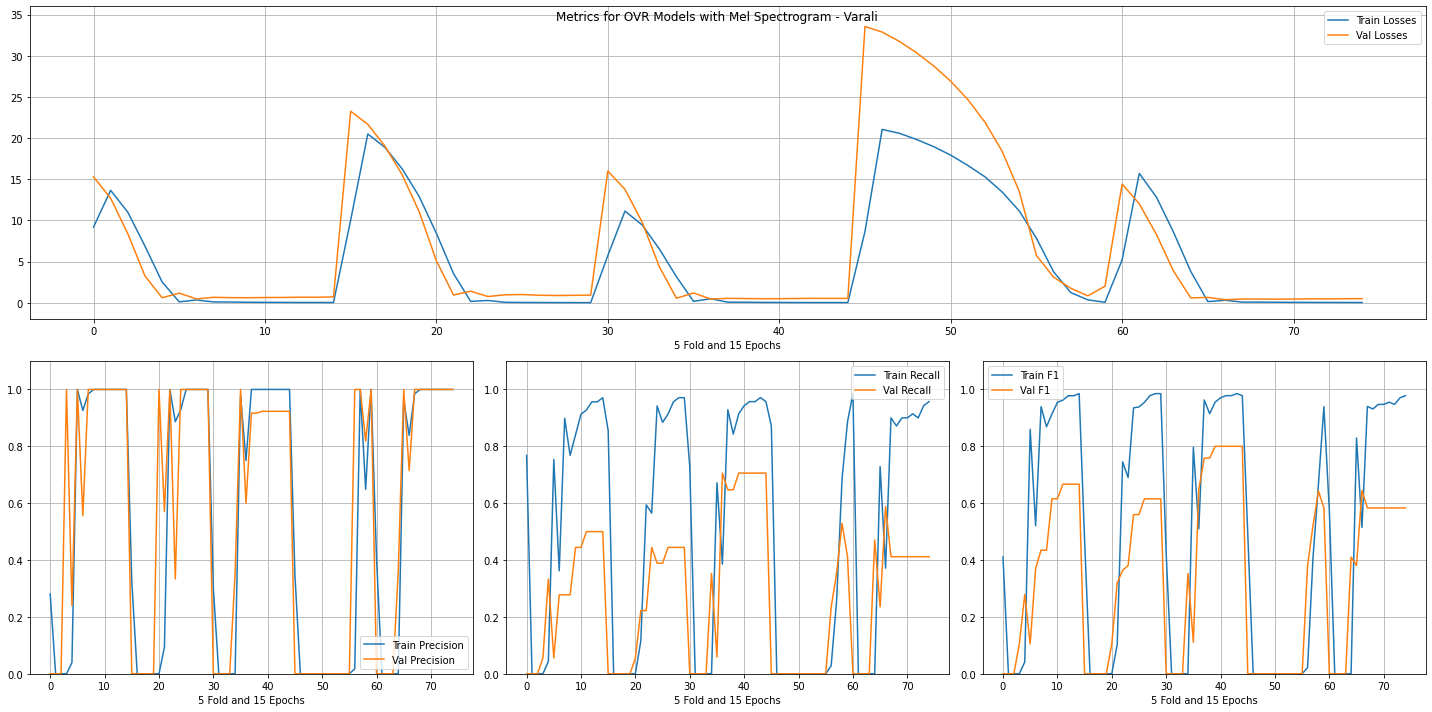

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.985507            0.8  ...      0.023523           0.525318
11  0.978102            0.8  ...      0.027301           0.518198
12  0.978102            0.8  ...      0.024380           0.531423
14  0.978102            0.8  ...      0.021425           0.526202
10  0.970588            0.8  ...      0.034535           0.494777
..       ...            ...  ...           ...                ...
9   0.000000            0.0  ...     11.147099          13.512339
10  0.000000            0.0  ...      7.837806           5.738981
1   0.000000            0.0  ...     15.710275          12.016589
2   0.000000            0.0  ...     12.827804           8.292392
3   0.000000            0.0  ...      8.554579           3.835735

[75 rows x 12 columns]


In [13]:
le = LabelEncoder()
le.fit(train_data['Ragam'])
labels = le.transform(le.classes_)
ovr_res, models = ovr_train_model(train_data, MelMatrixDataset, MelRaga, "OVR Models with Mel Spectrogram", 
                          labels, le.classes_, lbl_encoder=le, lr=1e-5, epochs=15, n_folds=5, feature='mel_spec',nindex_factor=5)

In [14]:
df = create_results_table(ovr_res, le, n_results=1)

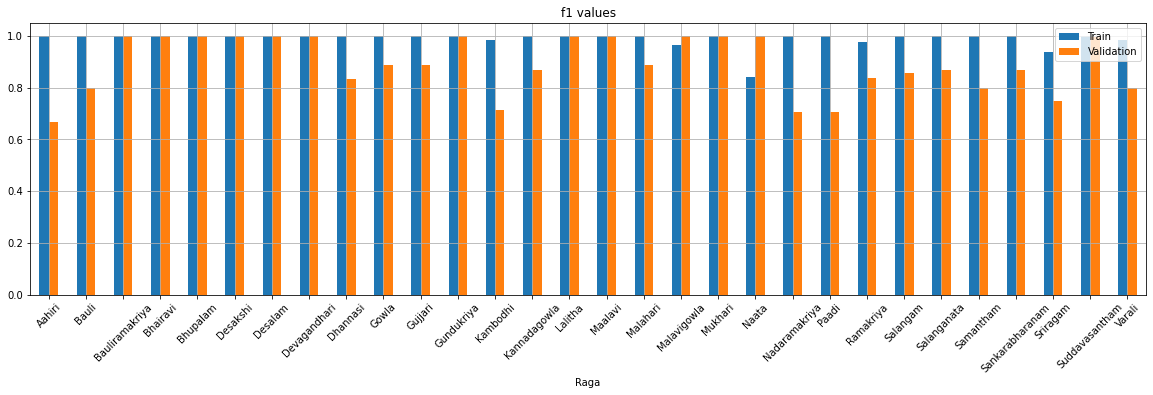

In [15]:
bar_plot(df, 'f1')

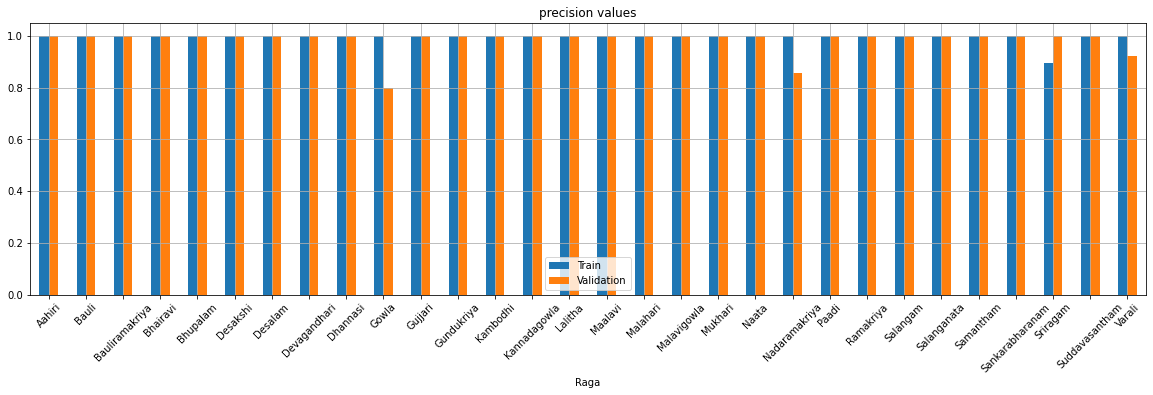

In [16]:
bar_plot(df, 'precision')

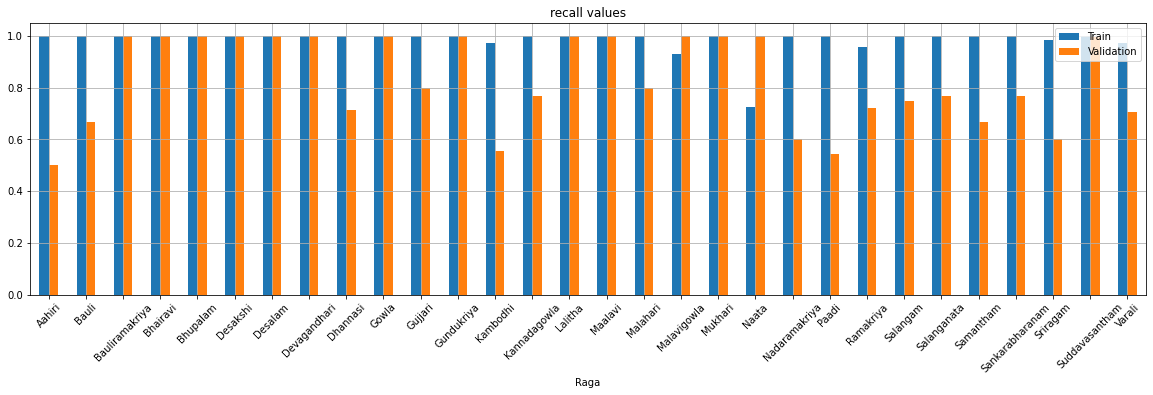

In [17]:
bar_plot(df, 'recall')

# Predict on test data set

In [18]:
test_preds = pd.DataFrame(columns=['Original','Predicted','Confidence'])
idx = 0
model_banks = load_models(models, MelRaga)
for i in test_data.index:
  test_preds.loc[idx, 'Original'] = test_data.loc[i, 'Ragam']
  test_preds.loc[idx, 'Predicted'], test_preds.loc[idx, 'Confidence'] = get_raga_name(predict(model_banks,test_data.loc[i,'mel_spec']))
  idx = idx + 1
test_preds['is_true'] = test_preds.apply(lambda x:x['Original']==x['Predicted'], axis=1)

In [19]:
print('Median Confidence Levels')
for g in test_preds.groupby('Predicted'):
  print(g[0], g[1]['Confidence'].median())

Median Confidence Levels
Bauli 0.977886974811554
Dhannasi 0.744186520576477
Gujjari 0.7046886682510376
Kambodhi 0.9999421834945679
Lalitha 0.999998927116394
Malahari 0.9279574155807495
Nadaramakriya 0.48685550689697266
Samantham 0.8621535301208496
Sankarabharanam 0.5339925736188889


In [20]:
print('Correctly classified Ragas')
test_preds[test_preds['is_true']]['Original'].value_counts()

Correctly classified Ragas


Malahari    3
Bauli       1
Name: Original, dtype: int64

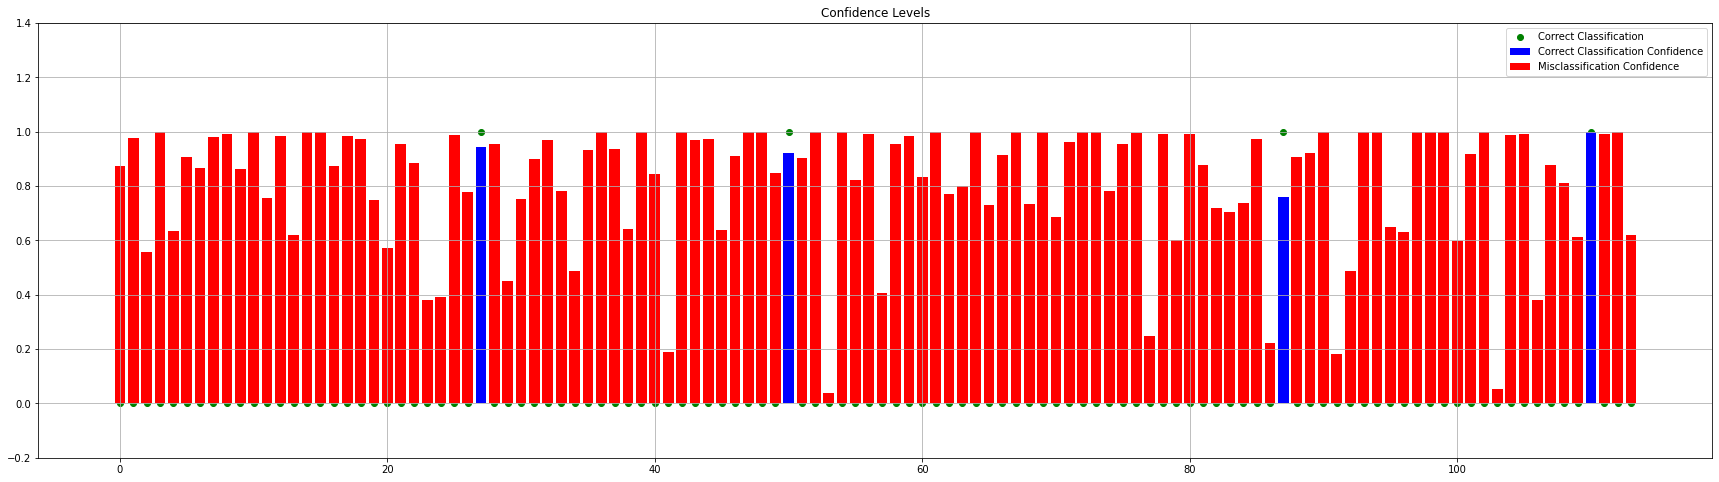

In [21]:
plt.figure(figsize=[30,8])
plt.scatter(test_preds.index, test_preds['is_true'],facecolor='g')
plt.bar(test_preds[test_preds['is_true']].index,test_preds[test_preds['is_true']]['Confidence'],facecolor='b')
plt.bar(test_preds[test_preds['is_true']!=True].index,test_preds[test_preds['is_true']!=True]['Confidence'],facecolor='r')
plt.grid(True)
plt.legend(['Correct Classification','Correct Classification Confidence','Misclassification Confidence'],loc='upper right')
plt.ylim([-0.2,1.4])
plt.title('Confidence Levels')
plt.show()

<Figure size 720x720 with 0 Axes>

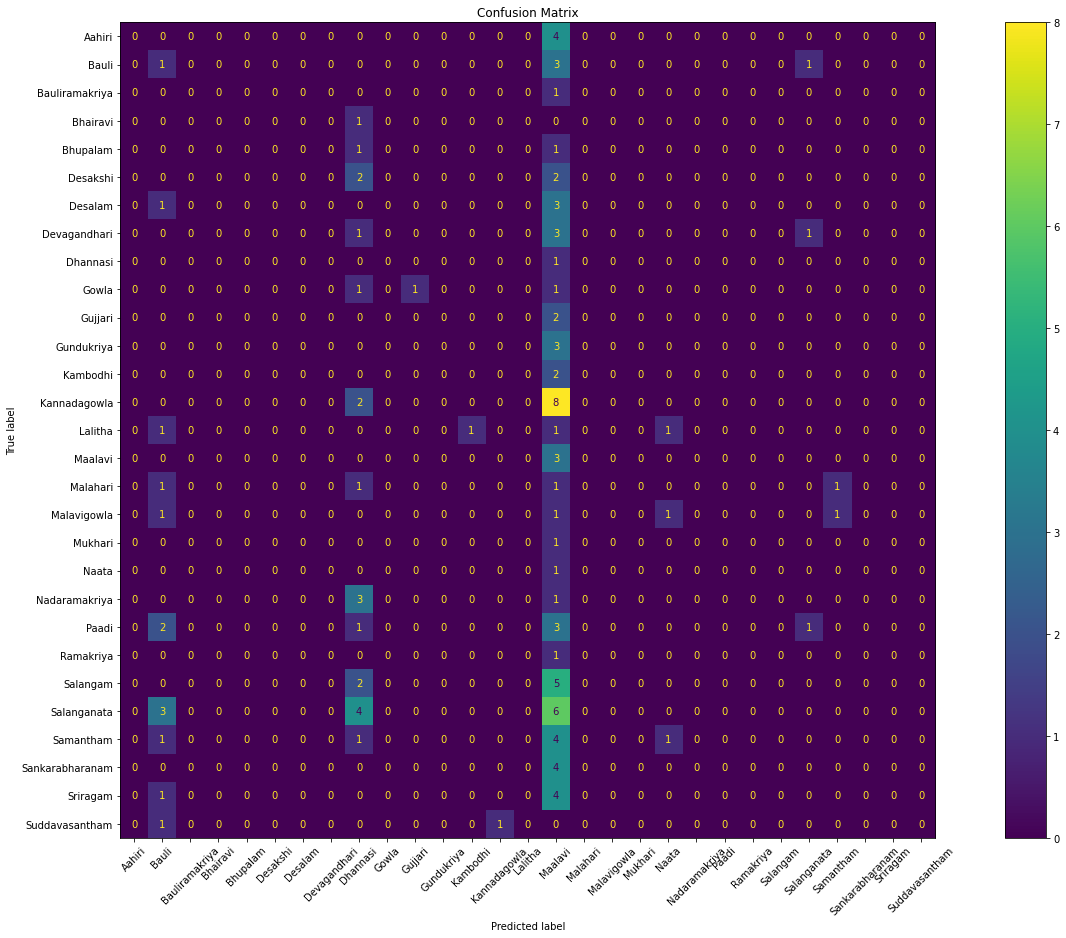

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=[10,10])
f = ConfusionMatrixDisplay(confusion_matrix(le.transform(test_preds['Original']),le.transform(test_preds['Predicted'])),display_labels=le.classes_)
f.plot(xticks_rotation=45)
f.figure_.set_size_inches([25,15])
plt.title('Confusion Matrix')
plt.show()

In [23]:
def print_metrics(df, average='micro'):
  print(f'With {average} average')
  print('F1 Score : ', f1_score(test_preds['Original'],test_preds['Predicted'],average=average))
  print('Precision : ', precision_score(test_preds['Original'],test_preds['Predicted'],average=average))
  print('Recall : ', recall_score(test_preds['Original'],test_preds['Predicted'],average=average))

print_metrics(test_preds)

With micro average
F1 Score :  0.03508771929824561
Precision :  0.03508771929824561
Recall :  0.03508771929824561
